# Advanced Lane Detection

This implementation tries to find the current driving lane of a car. It is based on the technicts taught in the online course ["Self Driving Car Engineer" from Udacity](https://udacity.com/course/self-driving-car-engineer-nanodegree--nd013) and on the paper ["Real time Detection of Lane Markers in Urban Streets" by Mohamed Aly](http://www.mohamedaly.info/research/lane-detection)


## Image Distortion and Top View

This helps to remove perspective effects in an images. Lines that are actually parallel, converge at the horizon in an images captured by a camera. The calculation of a top view gets rid of this effect, so that lanes appear parallel. 

In [160]:

import glob
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Read in the saved camera matrix and distortion coefficients
# See jupyter notebook Camera_Calibration.jpynb
dist_pickle = pickle.load( open( "camera_cal_data/camera_calibration_data.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

plt_img_width = 10
plt_img_height = 8

def top_view(img, mtx, dist):
    # undistort image
    img_undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    
    # top left, top right, bottom right, bottom left
    corners = [[603,440], [673,440], [1017, 660], [229,660]]
    
    img_height, img_width, img_depth = img.shape
    
    margin_horz = 250
    margin_vert = 0
   
    src_rect = np.float32(
        [corners[0], 
        corners[1],
        corners[2],
        corners[3]])

    dest_rect= np.float32([
        [margin_horz,             margin_vert],
        [img_width - margin_horz, margin_vert],
        [img_width - margin_horz, img_height - margin_vert],
        [margin_horz,             img_height - margin_vert]])

    M = cv2.getPerspectiveTransform(src_rect, dest_rect)
    Minv = cv2.getPerspectiveTransform(dest_rect, src_rect)
    warped = cv2.warpPerspective(img_undistorted, M, (img_width, img_height))
    return warped, M, Minv
                                 


This is an orignal image from camera

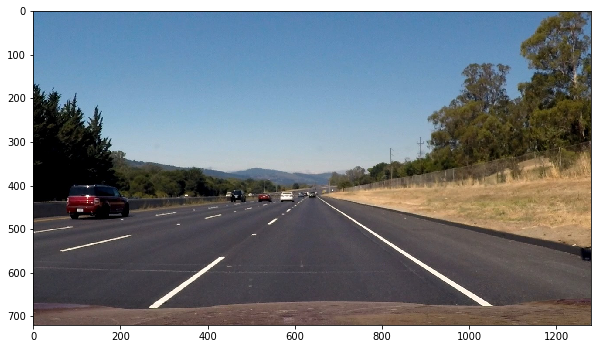

In [161]:
# read a distorted image
distorted_image = mpimg.imread('test_images/straight_lines2.jpg')

# show the distorted image
plt.figure(figsize=(plt_img_width,plt_img_height))
plt.imshow(distorted_image)


And this is the undistorted top view

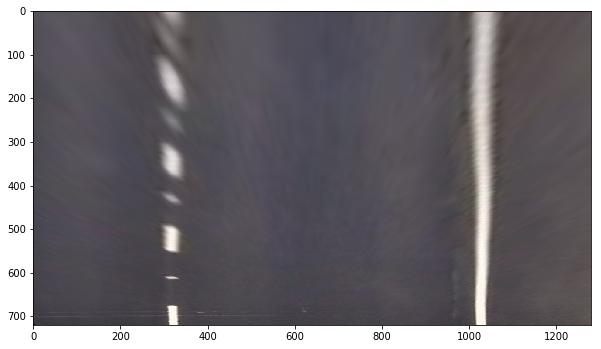

In [162]:
# read a distorted image
topview_image, M, Minv = top_view(distorted_image, mtx, dist) 

# show the distorted image
plt.figure(figsize=(plt_img_width,plt_img_height))
plt.imshow(topview_image)

# image dimensions
topview_image_height, topview_image_width, topview_image_depth = topview_image.shape 

This show the undistorted top view of all test images

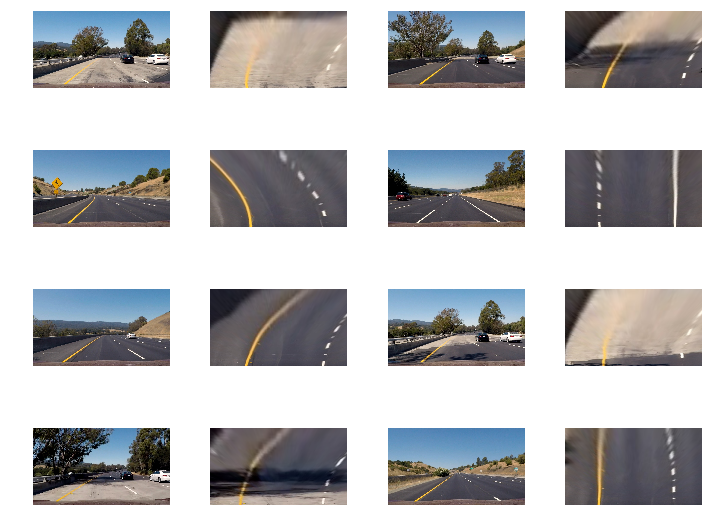

In [164]:
test_images_file_filter = 'test_images/*.jpg'
test_images_file_file_names = glob.glob(test_images_file_filter)
undistorted_top_views = []
distorted_images = []

fig, axs = plt.subplots(ncols=4, nrows=4, figsize=(plt_img_width, plt_img_height))
axs = axs.ravel()

for index, distorted_image_file_name in zip(range(len(test_images_file_file_names)), test_images_file_file_names):
    distorted_image = mpimg.imread(distorted_image_file_name)
    distorted_images.append(distorted_image)
    
    topview_image, M, Minv = top_view(distorted_image, mtx, dist)
    undistorted_top_views.append(topview_image)
    
    axs[index*2].imshow(distorted_image)
    axs[index*2].set_axis_off()
    axs[index*2+1].imshow(topview_image)
    axs[index*2+1].set_axis_off()
    
plt.tight_layout()


## Evaluation of color channel

Lane dividers have two major color properties, saturation and lightness, to contrast with the road. We may take advantages of this by transforming the image to the HLS color space.

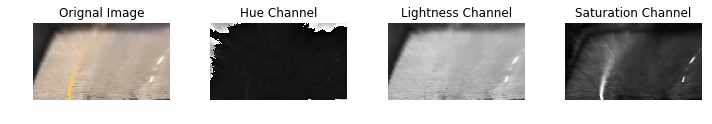

In [165]:
def show_hls_color_channels(channel_eval_image):
    hls_image = cv2.cvtColor(channel_eval_image, cv2.COLOR_RGB2HLS)
    h_channel = hls_image[:,:,0]
    l_channel = hls_image[:,:,1]
    s_channel = hls_image[:,:,2]
    
    fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(plt_img_width, plt_img_height))
    axs[0].set_title("Orignal Image")
    axs[0].imshow(channel_eval_image)
    axs[0].set_axis_off()
    axs[1].set_title("Hue Channel")
    axs[1].imshow(h_channel / 100.0, cmap='gray')
    axs[1].set_axis_off()
    axs[2].set_title("Lightness Channel")
    axs[2].imshow(l_channel, cmap='gray')
    axs[2].set_axis_off()
    axs[3].set_title("Saturation Channel")
    axs[3].imshow(s_channel, cmap='gray')
    axs[3].set_axis_off()
    plt.tight_layout()
    
show_hls_color_channels(undistorted_top_views[0])



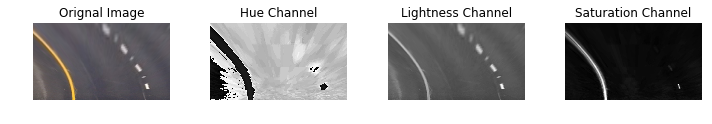

In [166]:
show_hls_color_channels(undistorted_top_views[2])

We can see that the saturation channel is suitable to extract yellow lines, whereas the lightness channel seems to extract white markes. 

## Marker extraction

Different to the approach from Udacity, I use gaussian spatial filters to detect vertical lines, as described in Mohamed Aly's paper on the lighness channel and on the saturation channel. The respons
e of this filter is then thresholded and merged.

In [167]:
# calucate the derivative of a gaussian
def get_derivative_gaussian(w, sigma):
    d = np.zeros(w*2+1)    
    
    for x in range(-w,w+1):
        i = x + w
        d[i] = (1.0/sigma**2) * np.exp((-(x**2)) / (2 * sigma**2)) * (1 - (x**2 / sigma**2)) 
    
    return d

# calculate a gaussian
def get_gaussian(w, sigma):
    g = np.zeros(w*2+1)
    
    for x in range(-w,w+1):
        i = x + w
        g[i] = np.exp(-((x**2)/(2*sigma**2)))
    
    return g

# combine the derivative of a gaussian and a gaussian to a kernel
def get_convolution_kernel(kernel_width, kernel_height, sigma_width, sigma_height):
    derivative_gaussian = np.mat(get_derivative_gaussian(kernel_width,sigma_width))
    gaussian = np.mat(get_gaussian(kernel_height, sigma_height))
    kernel = gaussian.T * derivative_gaussian
    return kernel


### Gaussian Curves


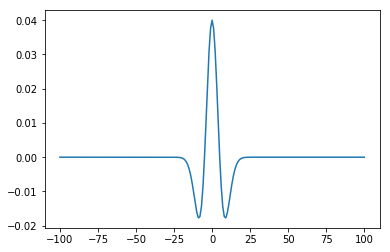

In [168]:
xm_per_pix = 3.7/700
ym_per_pix = 30.0/720

kernel_width = 100 # 25
sigma_width = 5 # 5
t1 = np.arange(-kernel_width, kernel_width+1)
plt.plot(t1, get_derivative_gaussian(kernel_width,sigma_width))

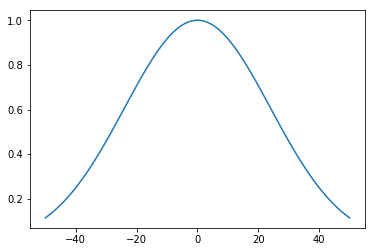

In [169]:
kernel_height = 50 #10
sigma_height = 24 # 6
t2 = np.arange(-kernel_height, kernel_height+1)
plt.plot(t2, get_gaussian(kernel_height,sigma_height))

### Spatial Filter Kernel


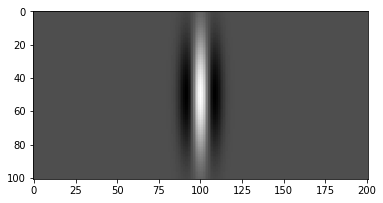

In [170]:
spatial_filter = get_convolution_kernel(kernel_width, kernel_height, sigma_width, sigma_height)
cv2.normalize(spatial_filter,spatial_filter)

plt.imshow(spatial_filter, cmap='gray')

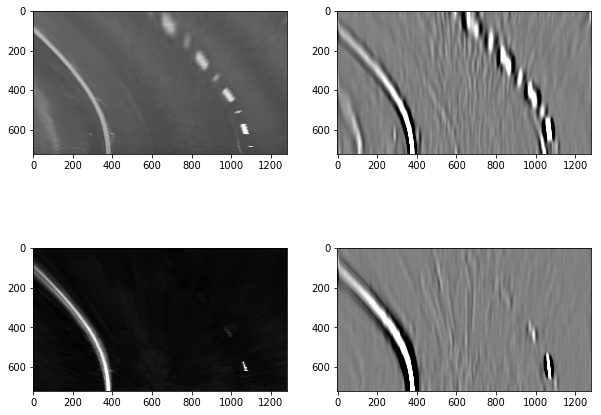

In [171]:
def filter_image(image, kernel):
    hls_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    #h_channel = hls_image[:,:,0]
    l_channel = hls_image[:,:,1]
    s_channel = hls_image[:,:,2]

    return cv2.filter2D(l_channel, 1, kernel), cv2.filter2D(s_channel, 1, kernel) 

image_idx = 2
distorted_image = distorted_images[image_idx]
image_to_filter = undistorted_top_views[image_idx]
filtered_l_channel, filtered_s_channel = filter_image(image_to_filter,spatial_filter)

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(plt_img_width, plt_img_height))
axs[0,0].imshow(cv2.cvtColor(image_to_filter, cv2.COLOR_RGB2HLS)[:,:,1], cmap='gray')
axs[0,1].imshow(filtered_l_channel, cmap='gray')
axs[1,0].imshow(cv2.cvtColor(image_to_filter, cv2.COLOR_RGB2HLS)[:,:,2], cmap='gray')
axs[1,1].imshow(filtered_s_channel, cmap='gray')


### Thresholded images


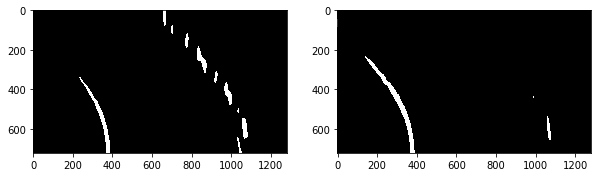

In [172]:
def threshold(image):
    normalized = cv2.normalize(
        image, 0,255,norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    
    _, normalized = cv2.threshold(normalized,248.0,255.0,cv2.THRESH_TOZERO)
    return normalized

normalized_filtered_l_channel = threshold(filtered_l_channel)
normalized_filtered_s_channel = threshold(filtered_s_channel)
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(plt_img_width, plt_img_height))
axs[0].imshow(normalized_filtered_l_channel, cmap='gray')
axs[1].imshow(normalized_filtered_s_channel, cmap='gray')


### Merged Image

The lanes stand out now clearly. Both images will be merged in next step by taking the maximum values of each image.

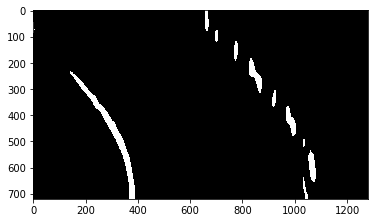

In [173]:
processed_image = np.maximum(normalized_filtered_l_channel, normalized_filtered_s_channel)
plt.imshow(processed_image, cmap='gray')

### Find Candidates for Lanes

The bottom part of the filtered and thresholded image is used as starting point to find lanes. A summation of the columns and smoothing of that part will show prominent peaks. This is where we start to extract lanes. 

In [174]:
def bottom_smoothed_histogram(image):
    height = image.shape[0]
    bottom = image[height - height//3:, :]
    histogram = np.sum(bottom, axis=0)
    
    smooth_histogram = cv2.GaussianBlur(
        src=np.float32(histogram), ksize=(1,19), sigmaX=19.0)
    
    '''
    window_width = 50
    window = np.ones(window_width)
    conv_signal = np.convolve(window, histogram)
    '''

    return np.int_(smooth_histogram.flatten())

# Create histogram of image binary activations
lane_histogram = bottom_smoothed_histogram(processed_image)

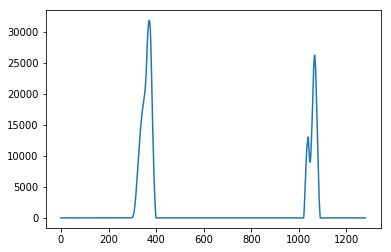

In [175]:
from skimage.feature import peak_local_max

# find the peaks in the histogram
histogram_peak_idx = peak_local_max(lane_histogram, min_distance=50, threshold_abs=400000)
histogram_peak_values =  lane_histogram[histogram_peak_idx]

# Visualize the resulting histogram and show the peaks
fig, ax = plt.subplots()
ax.plot(lane_histogram)
ax.plot(histogram_peak_idx,histogram_peak_values, '*')



### Find lanes

Sliding windows are drawn around the candidates and moved up along a probable path to the top of the images.


In [176]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        #length (ratio) of this line
        length = 0.0

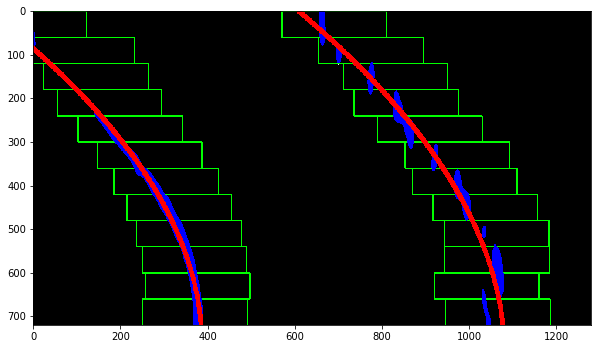

In [177]:
# get the middle point of plateaus 
def filter_local_maxima(local_maxima, gap):
    group = []
    filtered_local_maxima = []
    last_index = 0
    
    for maximum_index in local_maxima:
        if abs(maximum_index - last_index) > gap:
            group_size = len(group) 
            if group_size == 1:
                filtered_local_maxima.append(int(group[0]))
            
            if group_size > 1:
                filtered_local_maxima.append(int(group[0] + (group[group_size-1] - group[0]) / 2))
                
            group.clear()
        
        group.append(maximum_index)
        last_index = maximum_index

    group_size = len(group)
    
    if group_size == 1:
        filtered_local_maxima.append(int(group[0]))
    
    if group_size > 1:
        filtered_local_maxima.append(int(group[0] + (group[group_size-1] - group[0]) / 2))
                
    return filtered_local_maxima

    
def find_lane_pixels(image, n_search_windows, search_window_margin, minpix):
    out_img = np.dstack((image, image, image))
    
    lane_histogram = bottom_smoothed_histogram(image)
    
    # find the peaks in the histogram
    #histogram_peak_idxs = peak_local_max(lane_histogram, min_distance=50, threshold_abs=400000)
    histogram_peak_idxs = peak_local_max(lane_histogram, min_distance=50, threshold_abs=15000)
    
    
    # filter plateaus
    lane_positions = filter_local_maxima(histogram_peak_idxs, 10)
    
    #histogram_peak_values =  lane_histogram[histogram_peak_idxs]
    
    # Visualize the resulting histogram and show the peaks
    # fig, ax = plt.subplots()
    # ax.plot(lane_histogram)
    # ax.plot(histogram_peak_idxs,histogram_peak_values, '*')

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(image.shape[0]//n_search_windows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    good_lanes_inds = []
    lane_lengths = []
    
    image_height = image.shape[0]
    
    for lane_position_idx in range(len(lane_positions)):
        lane_inds = []
        current_lane_pos = lane_positions[lane_position_idx]
        last_shift = 0
        empty_box_count = 0
        max_empty_boxes = 3
        lane_length = 0.0
        
        for window in range(n_search_windows):
            win_y_low = image_height - (window + 1) * window_height
            win_y_high = image_height - window * window_height

            win_x_low = current_lane_pos - search_window_margin
            win_x_high = current_lane_pos + search_window_margin
            
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_x_low,win_y_low),
                (win_x_high,win_y_high),(0,255,0), 2)
            
            # Identify the nonzero pixels in x and y within the window #
            good_lane_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_x_low) &  (nonzerox < win_x_high)).nonzero()[0]
            
          
            ### If you found > minpix pixels, recenter next window ###
            if len(good_lane_inds) > minpix:
                new_lane_pos = np.int(np.mean(nonzerox[good_lane_inds]))
                last_shift = new_lane_pos - current_lane_pos
                current_lane_pos = new_lane_pos
                lane_inds.append(good_lane_inds)
                empty_box_count = 0
                lane_length += window_height
            else:
                current_lane_pos += last_shift
                empty_box_count += 1
                
            # if there are too many empty boxes stop search
            if (empty_box_count >= max_empty_boxes):
                break
    
        # Concatenate the arrays of indices (previously was a list of lists of pixels)        
        try:
            lane_inds = np.concatenate(lane_inds)
        except ValueError:
            # Avoids an error if the above is not implemented fully
            pass
            
        good_lanes_inds.append(lane_inds)    

    X = []
    Y = []
    
    # Extract left and right line pixel positions
    for lane_position_idx in range(len(lane_positions)):
        X.append(nonzerox[good_lanes_inds[lane_position_idx]])
        Y.append(nonzeroy[good_lanes_inds[lane_position_idx]])
    
    return X, Y, out_img

def get_lane_points(fit_params, image_height, max_points):
    # Generate x and y values for plotting
    ploty = np.linspace(0, image_height-1, max_points)
    
    try:
        fitx = fit_params[0]*ploty**2 + fit_params[1]*ploty + fit_params[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        fitx = 1*ploty**2 + 1*ploty
    
    return fitx, ploty
    

def lane_fitting(X, Y, image, draw):
    image_height = image.shape[0]
    fit_params_all_lanes = []
    
    for i in range(len(X)):        
        fit_params = np.polyfit(Y[i], X[i], 2)
        fit_params_all_lanes.append(fit_params)
        
        if draw == True:
            fitx, ploty = get_lane_points(fit_params, image_height, image_height)
            
            ## Visualization ##
            # Colors in the left and right lane regions
            image[Y[i], X[i]] = [0, 0, 255]
    
            # Plots the left and right polynomials on the lane lines
            laneline = np.array([np.transpose(np.vstack([fitx, ploty]))])
            cv2.polylines(image, np.int_([laneline]), False, (255,0, 0), thickness=10, lineType=4)
            #plt.plot(fitx, ploty, color='red')

    return fit_params_all_lanes        
        
lanes_x, lanes_y, sliding_window_image = find_lane_pixels(processed_image, 12, 120, 50)  
lane_fitting_params = lane_fitting(lanes_x, lanes_y, sliding_window_image, draw=True)
plt.figure(figsize=(plt_img_width,plt_img_height))    
plt.imshow(sliding_window_image)


### Search lanes around polynom

Polynoms that where found in prior search will be used to find lanes in the next image.

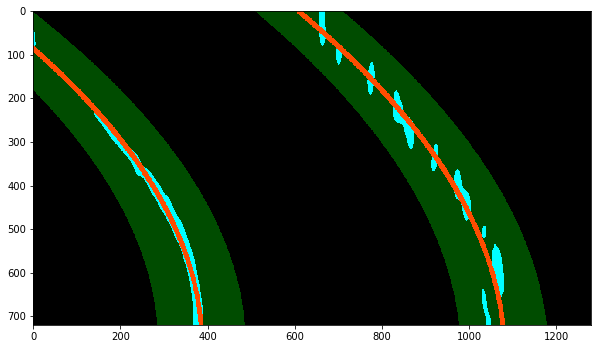

In [178]:
def search_lanes_around_polynoms(lanes_fitting_params, margin, image, draw):
    image_height = image.shape[0]
    
    # Grab activated pixels
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    out_img = []
    window_img = []
    result_image = []
    
    if draw == True:
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((image, image, image))*255
        window_img = np.zeros_like(out_img)
    
    for i in range(len(lanes_fitting_params)):
        lane_fitting_params = lanes_fitting_params[i]
        
        lane_inds = ((nonzerox > (lane_fitting_params[0]*(nonzeroy**2) + lane_fitting_params[1]*nonzeroy + 
                        lane_fitting_params[2] - margin)) & (nonzerox < (lane_fitting_params[0]*(nonzeroy**2) + 
                        lane_fitting_params[1]*nonzeroy + lane_fitting_params[2] + margin)))
    
        
        # Again, extract left and right line pixel positions
        lane_x = nonzerox[lane_inds]
        lane_y = nonzeroy[lane_inds] 
    
        # Fit new polynomials
        new_lane_fitting_params = lane_fitting([lane_x], [lane_y], image, draw=False)
        lanes_fitting_params[i] = new_lane_fitting_params[0]
        
        if draw == True:
            ## Visualization ##
            fitx, ploty = get_lane_points(new_lane_fitting_params[0], image_height, image_height)
        
        
            # Color on lane pixel
            out_img[nonzeroy[lane_inds], nonzerox[lane_inds]] = [0, 255, 255]
        
            # Generate a polygon to illustrate the search window area
            # And recast the x and y points into usable format for cv2.fillPoly()
            line_window1 = np.array([np.transpose(np.vstack([fitx-margin, ploty]))])
            line_window2 = np.array([np.flipud(np.transpose(np.vstack([fitx+margin, 
                                      ploty])))])
            line_pts = np.hstack((line_window1, line_window2))
        
            # Draw the lane onto the warped blank image
            cv2.fillPoly(window_img, np.int_([line_pts]), (0,255, 0))

            # Plot the polynomial lines onto the image
            laneline = np.array([np.transpose(np.vstack([fitx, ploty]))])
            cv2.polylines(out_img, np.int_([laneline]), False, (255,0, 0), thickness=10, lineType=4)

            result_image = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

            #plt.plot(fitx, ploty, color='red',  linewidth=5)
            ## End visualization steps ##
    
    return lanes_fitting_params, result_image

# Run image through the pipeline
processed_image_poly_lane_fit = processed_image.copy()
lanes_fitting_params, result_image = search_lanes_around_polynoms(lane_fitting_params, 100, processed_image_poly_lane_fit, draw=True)

# View your output
plt.figure(figsize=(plt_img_width,plt_img_height))    
plt.imshow(result_image)

### Getting Curvature from Polynoms

Curvature R is calculated for a second order polynomial 

$$f(y)=Ax^2+Bx+C$$

with this function:

$$R_{curve}=\frac{(1+(2Ay+B)^2)^{3/2}}{|2A|}$$



In [179]:
def meassure_curvature(polynomial, y, xm_per_pix, ym_per_pix, image_height):
    # generate new x and y values along the curve (use only a small subset of points)
    fitx, ploty = get_lane_points(polynomial, image_height, 50)
    fitx *= xm_per_pix
    ploty *= ym_per_pix
    
    # transform x and y coordinates to real world and fit a polynomial
    fit_params = np.polyfit(ploty, fitx, 2)
    
    A = fit_params[0]
    B = fit_params[1]
    R = 0
    
    y *= ym_per_pix
    
    if (A != 0.0):
        R = ((1 + (2 * A * y + B) ** 2) ** (3/2)) / np.abs(2 * A)
        
    return R, fitx[-1]

lane_points = []
xm_per_pix = 3.7/700
ym_per_pix = 30.0/720
Rs = []

for i in range(len(lanes_fitting_params)):
    image_height = processed_image.shape[0]
    R, lane_point = meassure_curvature(
        lane_fitting_params[i], y=(image_height - 1), xm_per_pix = xm_per_pix, ym_per_pix = ym_per_pix, image_height=image_height)
    lane_points.append(lane_point)
    Rs.append(R)
    print(R, "m")

219.70314165931177 m
198.16486462400664 m


### Vehicle Position

The vehicle position is calculated based on the bottom lane points and the center of the image. 

In [180]:
def get_vehicle_position(lane_points, image_width_in_m):
    pos_in_m = 0.0
    left = 0
    right = image_width_in_m
    middle = image_width_in_m / 2
    
    # get the closest points from center
    for lane_point in lane_points:
        if (lane_point > left and lane_point < middle):
            left = lane_point
        
        if (lane_point > middle and lane_point < right):
            right = lane_point
            
    pos_in_m = ((left + right) / 2 - middle)
    return pos_in_m

image_width = processed_image.shape[1]
car_position = get_vehicle_position(lane_points, image_width * xm_per_pix)
print('Car Position:', car_position, 'm')
    

Car Position: 0.48560022352975807 m


### Show current lane in the original image

[array([-7.47728290e-04,  1.18923892e+00,  6.09549793e+02]), array([-8.28875116e-04,  1.27475149e+00, -1.02375799e+02])]


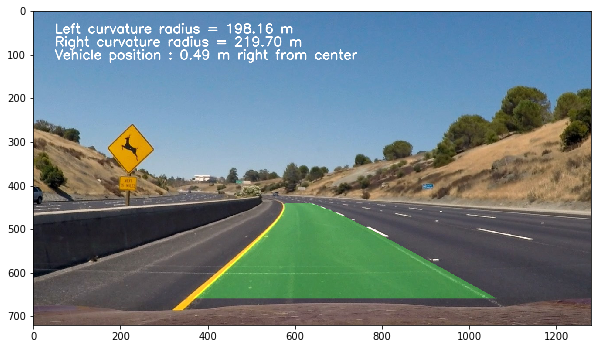

In [181]:
def get_left_right_params(lanes_fitting_params, image_height, image_width):
    bottom_y = image_height - 1 
    middle = image_width / 2
    left = 0
    right = image_width - 1
    left_params = []
    right_params = []
    lane_points = []
    left_i = -1
    right_i = -1
    
    # get the closest points from center
    for fit_params in lanes_fitting_params:
        try:
            fitx = fit_params[0]*bottom_y**2 + fit_params[1]*bottom_y + fit_params[2]
            lane_points.append(fitx)
            
        except TypeError:
            # Avoids an error if `left` and `right_fit` are still none or incorrect
            print('The function failed to fit a line!')
            fitx = 1*bottom_y**2 + 1*bottom_y
            lane_points.append(fitx)     
        
    for i in range(len(lane_points)):
        lane_point = lane_points[i]
        if (lane_point > left and lane_point < middle):
            left = lane_point
            left_params = lanes_fitting_params[i]
            left_i = i
        
        if (lane_point >= middle and lane_point < right):
            right = lane_point
            right_params = lanes_fitting_params[i]
            right_i = i
            
    return left_params, left_i, right_params, right_i

    
def draw_current_lane_on_image(processed_image, original_image, lanes_fitting_params, Minv, 
                               Rs, position):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(processed_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    image_height = processed_image.shape[0]
    image_width = processed_image.shape[1]

    # get only the left and right lane parameters
    left_params, left_i, right_params, right_i = get_left_right_params(
        lanes_fitting_params, image_height=image_height, image_width=image_width)
    
    if len(left_params) == 0 or len(right_params) == 0:
        return original_image

    R_left = Rs[left_i]
    R_right = Rs[right_i]
    
    left_fitx, ploty = get_lane_points(left_params, image_height, image_height)
    right_fitx, ploty = get_lane_points(right_params, image_height, image_height)
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image_width, image_height)) 
    # Combine the result with the original image
    result = cv2.addWeighted(original_image, 1, newwarp, 0.3, 0)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result,'Left curvature radius = %.2f m'%(R_left),(50,50), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result,'Right curvature radius = %.2f m'%(R_right),(50,80), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result,'Vehicle position : %.2f m %s from center'%(abs(position), 'left' if position < 0 else 'right'),(50,110), 
                        font, 1,(255,255,255),2,cv2.LINE_AA)
    return result

print(lane_fitting_params)    
plt.figure(figsize=(plt_img_width,plt_img_height))    
plt.imshow(draw_current_lane_on_image(
    processed_image, distorted_image, lane_fitting_params, Minv=Minv, Rs=Rs, position=car_position))


## The Pipeline

Now I put everything together to detect the lane in a video. While detection lanes I measure how much may I trust the new results. Based on that score I update the previous measurement. 

In [152]:
def lane_detection_pipeline(distorted_image):
    xm_per_pix = 3.7/700
    ym_per_pix = 30.0/720
    Rs = []

    # read a distorted image
    topview_image, M, Minv = top_view(distorted_image, mtx, dist)
    
    # filter image for lanes and get the saturation and lightness channel
    filtered_l_channel, filtered_s_channel = filter_image(topview_image,spatial_filter)
    
    # normalize and threshold the two channels
    normalized_filtered_l_channel = threshold(filtered_l_channel)
    normalized_filtered_s_channel = threshold(filtered_s_channel)
    
    # merge channels into one image
    processed_image = np.maximum(normalized_filtered_l_channel, normalized_filtered_s_channel)
    
    # This creates a smoothed histogram on the bottom part of the image
    # The local maximal in the histogram are used as start points to search for lanes
    lanes_x, lanes_y, sliding_window_image = find_lane_pixels(processed_image, 12, 120, 50)  
    lane_fitting_params = lane_fitting(lanes_x, lanes_y, sliding_window_image, draw=True)
    
    #return sliding_window_image
    return cv2.addWeighted(topview_image, 1, sliding_window_image, 0.3, 0)
    
    image_height = processed_image.shape[0]
    image_width = processed_image.shape[1]

    # We are only interested in a left and right lane
    left_params, left_i, right_params, right_i = get_left_right_params(
        lane_fitting_params, image_height=image_height, image_width=image_width)
    
    lane_fitting_params = [left_params, right_params]
    
    Rs = [0,0]
    lane_bottom_points = [0,0]

    Rs[0], lane_bottom_points[0] = meassure_curvature(
        lane_fitting_params[0], y=(image_height - 1), xm_per_pix = xm_per_pix, ym_per_pix = ym_per_pix, image_height=image_height)
        
    Rs[1], lane_bottom_points[1] = meassure_curvature(
        lane_fitting_params[1], y=(image_height - 1), xm_per_pix = xm_per_pix, ym_per_pix = ym_per_pix, image_height=image_height)

    car_position = get_vehicle_position(lane_bottom_points, image_width * xm_per_pix)
    
    return draw_current_lane_on_image(
        processed_image, distorted_image, lane_fitting_params, Minv=Minv, Rs=Rs, position=car_position)

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

video_file_name = "project_video"
video_file_name_ext = ".mp4"
output_video_file_name = "output_video/"+video_file_name + "_output" + video_file_name_ext
#video = VideoFileClip(video_file_name + video_file_name_ext).subclip(20,25)
video = VideoFileClip(video_file_name + video_file_name_ext)
output_video = video.fl_image(lane_detection_pipeline)
%time output_video.write_videofile(output_video_file_name, audio=False)

    

[MoviePy] >>>> Building video output_video/project_video_output.mp4


[MoviePy] Writing video output_video/project_video_output.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:00<04:10,  5.03it/s]

  0%|          | 2/1261 [00:00<04:27,  4.70it/s]

  0%|          | 3/1261 [00:00<04:10,  5.02it/s]

  0%|          | 4/1261 [00:00<04:07,  5.08it/s]

  0%|          | 5/1261 [00:00<03:56,  5.31it/s]

  0%|          | 6/1261 [00:01<03:50,  5.45it/s]

  1%|          | 7/1261 [00:01<03:49,  5.46it/s]

  1%|          | 8/1261 [00:01<03:44,  5.59it/s]

  1%|          | 9/1261 [00:01<03:39,  5.69it/s]

  1%|          | 10/1261 [00:01<03:36,  5.77it/s]

  1%|          | 11/1261 [00:01<03:33,  5.85it/s]

  1%|          | 12/1261 [00:02<03:31,  5.89it/s]

  1%|          | 13/1261 [00:02<03:29,  5.95it/s]

  1%|          | 14/1261 [00:02<03:28,  5.98it/s]

  1%|          | 15/1261 [00:02<03:26,  6.02it/s]

  1%|▏         | 16/1261 [00:02<03:25,  6.05it/s]

  1%|▏         | 17/1261 [00:02<03:24,  6.08it/s]

  1%|▏         | 18/1261 [00:02<03:23,  6.12it/s]

  2%|▏         | 19/1261 [00:03<03:21,  6.16it/s]

  2%|▏         | 20/1261 [00:03<03:20,  6.18it/s]

  2%|▏         | 21/1261 [00:03<03:19,  6.22it/s]

  2%|▏         | 22/1261 [00:03<03:18,  6.26it/s]

  2%|▏         | 23/1261 [00:03<03:17,  6.28it/s]

  2%|▏         | 24/1261 [00:03<03:16,  6.30it/s]

  2%|▏         | 25/1261 [00:03<03:15,  6.33it/s]

  2%|▏         | 26/1261 [00:04<03:14,  6.35it/s]

  2%|▏         | 27/1261 [00:04<03:13,  6.37it/s]

  2%|▏         | 28/1261 [00:04<03:13,  6.39it/s]

  2%|▏         | 29/1261 [00:04<03:12,  6.39it/s]

  2%|▏         | 30/1261 [00:04<03:12,  6.41it/s]

  2%|▏         | 31/1261 [00:04<03:11,  6.43it/s]

  3%|▎         | 32/1261 [00:04<03:10,  6.45it/s]

  3%|▎         | 33/1261 [00:05<03:09,  6.47it/s]

  3%|▎         | 34/1261 [00:05<03:09,  6.48it/s]

  3%|▎         | 35/1261 [00:05<03:08,  6.49it/s]

  3%|▎         | 36/1261 [00:05<03:08,  6.51it/s]

  3%|▎         | 37/1261 [00:05<03:07,  6.52it/s]

  3%|▎         | 38/1261 [00:05<03:07,  6.54it/s]

  3%|▎         | 39/1261 [00:05<03:06,  6.55it/s]

  3%|▎         | 40/1261 [00:06<03:06,  6.56it/s]

  3%|▎         | 41/1261 [00:06<03:05,  6.57it/s]

  3%|▎         | 42/1261 [00:06<03:05,  6.58it/s]

  3%|▎         | 43/1261 [00:06<03:05,  6.56it/s]

  3%|▎         | 44/1261 [00:06<03:05,  6.56it/s]

  4%|▎         | 45/1261 [00:06<03:05,  6.57it/s]

  4%|▎         | 46/1261 [00:06<03:04,  6.58it/s]

  4%|▎         | 47/1261 [00:07<03:04,  6.59it/s]

  4%|▍         | 48/1261 [00:07<03:04,  6.59it/s]

  4%|▍         | 49/1261 [00:07<03:03,  6.60it/s]

  4%|▍         | 50/1261 [00:07<03:03,  6.60it/s]

  4%|▍         | 51/1261 [00:07<03:03,  6.60it/s]

  4%|▍         | 52/1261 [00:07<03:03,  6.60it/s]

  4%|▍         | 53/1261 [00:08<03:02,  6.61it/s]

  4%|▍         | 54/1261 [00:08<03:02,  6.61it/s]

  4%|▍         | 55/1261 [00:08<03:02,  6.59it/s]

  4%|▍         | 56/1261 [00:08<03:02,  6.60it/s]

  5%|▍         | 57/1261 [00:08<03:02,  6.60it/s]

  5%|▍         | 58/1261 [00:08<03:02,  6.61it/s]

  5%|▍         | 59/1261 [00:08<03:01,  6.61it/s]

  5%|▍         | 60/1261 [00:09<03:01,  6.61it/s]

  5%|▍         | 61/1261 [00:09<03:01,  6.61it/s]

  5%|▍         | 62/1261 [00:09<03:01,  6.61it/s]

  5%|▍         | 63/1261 [00:09<03:01,  6.62it/s]

  5%|▌         | 64/1261 [00:09<03:00,  6.61it/s]

  5%|▌         | 65/1261 [00:09<03:00,  6.62it/s]

  5%|▌         | 66/1261 [00:09<03:00,  6.62it/s]

  5%|▌         | 67/1261 [00:10<03:00,  6.62it/s]

  5%|▌         | 68/1261 [00:10<03:00,  6.62it/s]

  5%|▌         | 69/1261 [00:10<02:59,  6.62it/s]

  6%|▌         | 70/1261 [00:10<02:59,  6.63it/s]

  6%|▌         | 71/1261 [00:10<02:59,  6.63it/s]

  6%|▌         | 72/1261 [00:10<02:59,  6.63it/s]

  6%|▌         | 73/1261 [00:11<02:59,  6.61it/s]

  6%|▌         | 74/1261 [00:11<02:59,  6.60it/s]

  6%|▌         | 75/1261 [00:11<02:59,  6.60it/s]

  6%|▌         | 76/1261 [00:11<02:59,  6.60it/s]

  6%|▌         | 77/1261 [00:11<02:59,  6.60it/s]

  6%|▌         | 78/1261 [00:11<02:59,  6.60it/s]

  6%|▋         | 79/1261 [00:11<02:59,  6.60it/s]

  6%|▋         | 80/1261 [00:12<02:58,  6.61it/s]

  6%|▋         | 81/1261 [00:12<02:58,  6.60it/s]

  7%|▋         | 82/1261 [00:12<02:58,  6.60it/s]

  7%|▋         | 83/1261 [00:12<02:58,  6.60it/s]

  7%|▋         | 84/1261 [00:12<02:58,  6.59it/s]

  7%|▋         | 85/1261 [00:12<02:58,  6.57it/s]

  7%|▋         | 86/1261 [00:13<02:59,  6.56it/s]

  7%|▋         | 87/1261 [00:13<02:59,  6.55it/s]

  7%|▋         | 88/1261 [00:13<02:59,  6.54it/s]

  7%|▋         | 89/1261 [00:13<02:59,  6.54it/s]

  7%|▋         | 90/1261 [00:13<02:58,  6.55it/s]

  7%|▋         | 91/1261 [00:13<02:58,  6.54it/s]

  7%|▋         | 92/1261 [00:14<02:59,  6.52it/s]

  7%|▋         | 93/1261 [00:14<02:59,  6.49it/s]

  7%|▋         | 94/1261 [00:14<02:59,  6.49it/s]

  8%|▊         | 95/1261 [00:14<02:59,  6.49it/s]

  8%|▊         | 96/1261 [00:14<02:59,  6.49it/s]

  8%|▊         | 97/1261 [00:14<02:59,  6.49it/s]

  8%|▊         | 98/1261 [00:15<02:59,  6.49it/s]

  8%|▊         | 99/1261 [00:15<02:58,  6.49it/s]

  8%|▊         | 100/1261 [00:15<02:58,  6.50it/s]

  8%|▊         | 101/1261 [00:15<02:58,  6.49it/s]

  8%|▊         | 102/1261 [00:15<02:58,  6.49it/s]

  8%|▊         | 103/1261 [00:15<02:58,  6.49it/s]

  8%|▊         | 104/1261 [00:16<02:58,  6.49it/s]

  8%|▊         | 105/1261 [00:16<02:57,  6.50it/s]

  8%|▊         | 106/1261 [00:16<02:57,  6.50it/s]

  8%|▊         | 107/1261 [00:16<02:57,  6.50it/s]

  9%|▊         | 108/1261 [00:16<02:57,  6.50it/s]

  9%|▊         | 109/1261 [00:16<02:57,  6.50it/s]

  9%|▊         | 110/1261 [00:16<02:56,  6.51it/s]

  9%|▉         | 111/1261 [00:17<02:56,  6.51it/s]

  9%|▉         | 112/1261 [00:17<02:56,  6.51it/s]

  9%|▉         | 113/1261 [00:17<02:56,  6.51it/s]

  9%|▉         | 114/1261 [00:17<02:55,  6.52it/s]

  9%|▉         | 115/1261 [00:17<02:55,  6.52it/s]

  9%|▉         | 116/1261 [00:17<02:55,  6.52it/s]

  9%|▉         | 117/1261 [00:17<02:55,  6.52it/s]

  9%|▉         | 118/1261 [00:18<02:55,  6.52it/s]

  9%|▉         | 119/1261 [00:18<02:55,  6.52it/s]

 10%|▉         | 120/1261 [00:18<02:55,  6.52it/s]

 10%|▉         | 121/1261 [00:18<02:54,  6.52it/s]

 10%|▉         | 122/1261 [00:18<02:54,  6.52it/s]

 10%|▉         | 123/1261 [00:18<02:54,  6.53it/s]

 10%|▉         | 124/1261 [00:18<02:54,  6.53it/s]

 10%|▉         | 125/1261 [00:19<02:53,  6.53it/s]

 10%|▉         | 126/1261 [00:19<02:53,  6.54it/s]

 10%|█         | 127/1261 [00:19<02:53,  6.54it/s]

 10%|█         | 128/1261 [00:19<02:53,  6.54it/s]

 10%|█         | 129/1261 [00:19<02:53,  6.54it/s]

 10%|█         | 130/1261 [00:19<02:52,  6.54it/s]

 10%|█         | 131/1261 [00:20<02:52,  6.55it/s]

 10%|█         | 132/1261 [00:20<02:52,  6.55it/s]

 11%|█         | 133/1261 [00:20<02:52,  6.55it/s]

 11%|█         | 134/1261 [00:20<02:52,  6.55it/s]

 11%|█         | 135/1261 [00:20<02:52,  6.54it/s]

 11%|█         | 136/1261 [00:20<02:51,  6.54it/s]

 11%|█         | 137/1261 [00:20<02:51,  6.55it/s]

 11%|█         | 138/1261 [00:21<02:51,  6.55it/s]

 11%|█         | 139/1261 [00:21<02:51,  6.55it/s]

 11%|█         | 140/1261 [00:21<02:50,  6.56it/s]

 11%|█         | 141/1261 [00:21<02:50,  6.56it/s]

 11%|█▏        | 142/1261 [00:21<02:50,  6.56it/s]

 11%|█▏        | 143/1261 [00:21<02:50,  6.56it/s]

 11%|█▏        | 144/1261 [00:21<02:50,  6.56it/s]

 11%|█▏        | 145/1261 [00:22<02:49,  6.57it/s]

 12%|█▏        | 146/1261 [00:22<02:49,  6.57it/s]

 12%|█▏        | 147/1261 [00:22<02:49,  6.57it/s]

 12%|█▏        | 148/1261 [00:22<02:49,  6.57it/s]

 12%|█▏        | 149/1261 [00:22<02:49,  6.57it/s]

 12%|█▏        | 150/1261 [00:22<02:49,  6.56it/s]

 12%|█▏        | 151/1261 [00:23<02:49,  6.56it/s]

 12%|█▏        | 152/1261 [00:23<02:49,  6.56it/s]

 12%|█▏        | 153/1261 [00:23<02:48,  6.56it/s]

 12%|█▏        | 154/1261 [00:23<02:49,  6.55it/s]

 12%|█▏        | 155/1261 [00:23<02:49,  6.54it/s]

 12%|█▏        | 156/1261 [00:23<02:48,  6.55it/s]

 12%|█▏        | 157/1261 [00:23<02:48,  6.54it/s]

 13%|█▎        | 158/1261 [00:24<02:48,  6.55it/s]

 13%|█▎        | 159/1261 [00:24<02:48,  6.55it/s]

 13%|█▎        | 160/1261 [00:24<02:48,  6.55it/s]

 13%|█▎        | 161/1261 [00:24<02:47,  6.55it/s]

 13%|█▎        | 162/1261 [00:24<02:47,  6.55it/s]

 13%|█▎        | 163/1261 [00:24<02:47,  6.55it/s]

 13%|█▎        | 164/1261 [00:25<02:47,  6.56it/s]

 13%|█▎        | 165/1261 [00:25<02:47,  6.56it/s]

 13%|█▎        | 166/1261 [00:25<02:46,  6.56it/s]

 13%|█▎        | 167/1261 [00:25<02:46,  6.56it/s]

 13%|█▎        | 168/1261 [00:25<02:46,  6.56it/s]

 13%|█▎        | 169/1261 [00:25<02:46,  6.57it/s]

 13%|█▎        | 170/1261 [00:25<02:46,  6.57it/s]

 14%|█▎        | 171/1261 [00:26<02:46,  6.56it/s]

 14%|█▎        | 172/1261 [00:26<02:45,  6.56it/s]

 14%|█▎        | 173/1261 [00:26<02:45,  6.57it/s]

 14%|█▍        | 174/1261 [00:26<02:45,  6.57it/s]

 14%|█▍        | 175/1261 [00:26<02:45,  6.57it/s]

 14%|█▍        | 176/1261 [00:26<02:45,  6.57it/s]

 14%|█▍        | 177/1261 [00:26<02:44,  6.57it/s]

 14%|█▍        | 178/1261 [00:27<02:44,  6.58it/s]

 14%|█▍        | 179/1261 [00:27<02:44,  6.58it/s]

 14%|█▍        | 180/1261 [00:27<02:44,  6.58it/s]

 14%|█▍        | 181/1261 [00:27<02:44,  6.58it/s]

 14%|█▍        | 182/1261 [00:27<02:43,  6.58it/s]

 15%|█▍        | 183/1261 [00:27<02:43,  6.58it/s]

 15%|█▍        | 184/1261 [00:28<02:43,  6.57it/s]

 15%|█▍        | 185/1261 [00:28<02:43,  6.57it/s]

 15%|█▍        | 186/1261 [00:28<02:43,  6.57it/s]

 15%|█▍        | 187/1261 [00:28<02:43,  6.57it/s]

 15%|█▍        | 188/1261 [00:28<02:43,  6.57it/s]

 15%|█▍        | 189/1261 [00:28<02:43,  6.57it/s]

 15%|█▌        | 190/1261 [00:28<02:42,  6.57it/s]

 15%|█▌        | 191/1261 [00:29<02:42,  6.57it/s]

 15%|█▌        | 192/1261 [00:29<02:42,  6.57it/s]

 15%|█▌        | 193/1261 [00:29<02:42,  6.58it/s]

 15%|█▌        | 194/1261 [00:29<02:42,  6.58it/s]

 15%|█▌        | 195/1261 [00:29<02:42,  6.58it/s]

 16%|█▌        | 196/1261 [00:29<02:41,  6.58it/s]

 16%|█▌        | 197/1261 [00:29<02:41,  6.58it/s]

 16%|█▌        | 198/1261 [00:30<02:41,  6.58it/s]

 16%|█▌        | 199/1261 [00:30<02:41,  6.58it/s]

 16%|█▌        | 200/1261 [00:30<02:41,  6.58it/s]

 16%|█▌        | 201/1261 [00:30<02:41,  6.58it/s]

 16%|█▌        | 202/1261 [00:30<02:40,  6.58it/s]

 16%|█▌        | 203/1261 [00:30<02:40,  6.58it/s]

 16%|█▌        | 204/1261 [00:30<02:40,  6.58it/s]

 16%|█▋        | 205/1261 [00:31<02:40,  6.58it/s]

 16%|█▋        | 206/1261 [00:31<02:40,  6.58it/s]

 16%|█▋        | 207/1261 [00:31<02:40,  6.58it/s]

 16%|█▋        | 208/1261 [00:31<02:39,  6.58it/s]

 17%|█▋        | 209/1261 [00:31<02:39,  6.58it/s]

 17%|█▋        | 210/1261 [00:31<02:39,  6.58it/s]

 17%|█▋        | 211/1261 [00:32<02:39,  6.58it/s]

 17%|█▋        | 212/1261 [00:32<02:39,  6.58it/s]

 17%|█▋        | 213/1261 [00:32<02:39,  6.57it/s]

 17%|█▋        | 214/1261 [00:32<02:39,  6.57it/s]

 17%|█▋        | 215/1261 [00:32<02:39,  6.57it/s]

 17%|█▋        | 216/1261 [00:32<02:38,  6.57it/s]

 17%|█▋        | 217/1261 [00:33<02:38,  6.57it/s]

 17%|█▋        | 218/1261 [00:33<02:38,  6.57it/s]

 17%|█▋        | 219/1261 [00:33<02:38,  6.57it/s]

 17%|█▋        | 220/1261 [00:33<02:38,  6.57it/s]

 18%|█▊        | 221/1261 [00:33<02:38,  6.57it/s]

 18%|█▊        | 222/1261 [00:33<02:38,  6.57it/s]

 18%|█▊        | 223/1261 [00:33<02:37,  6.57it/s]

 18%|█▊        | 224/1261 [00:34<02:37,  6.57it/s]

 18%|█▊        | 225/1261 [00:34<02:37,  6.57it/s]

 18%|█▊        | 226/1261 [00:34<02:37,  6.57it/s]

 18%|█▊        | 227/1261 [00:34<02:37,  6.57it/s]

 18%|█▊        | 228/1261 [00:34<02:37,  6.57it/s]

 18%|█▊        | 229/1261 [00:34<02:37,  6.57it/s]

 18%|█▊        | 230/1261 [00:35<02:36,  6.57it/s]

 18%|█▊        | 231/1261 [00:35<02:36,  6.57it/s]

 18%|█▊        | 232/1261 [00:35<02:36,  6.57it/s]

 18%|█▊        | 233/1261 [00:35<02:36,  6.57it/s]

 19%|█▊        | 234/1261 [00:35<02:36,  6.57it/s]

 19%|█▊        | 235/1261 [00:35<02:36,  6.58it/s]

 19%|█▊        | 236/1261 [00:35<02:35,  6.58it/s]

 19%|█▉        | 237/1261 [00:36<02:35,  6.58it/s]

 19%|█▉        | 238/1261 [00:36<02:35,  6.58it/s]

 19%|█▉        | 239/1261 [00:36<02:35,  6.58it/s]

 19%|█▉        | 240/1261 [00:36<02:35,  6.57it/s]

 19%|█▉        | 241/1261 [00:36<02:35,  6.58it/s]

 19%|█▉        | 242/1261 [00:36<02:34,  6.58it/s]

 19%|█▉        | 243/1261 [00:36<02:34,  6.58it/s]

 19%|█▉        | 244/1261 [00:37<02:34,  6.57it/s]

 19%|█▉        | 245/1261 [00:37<02:34,  6.57it/s]

 20%|█▉        | 246/1261 [00:37<02:34,  6.57it/s]

 20%|█▉        | 247/1261 [00:37<02:34,  6.56it/s]

 20%|█▉        | 248/1261 [00:37<02:34,  6.56it/s]

 20%|█▉        | 249/1261 [00:37<02:34,  6.56it/s]

 20%|█▉        | 250/1261 [00:38<02:33,  6.57it/s]

 20%|█▉        | 251/1261 [00:38<02:33,  6.57it/s]

 20%|█▉        | 252/1261 [00:38<02:33,  6.56it/s]

 20%|██        | 253/1261 [00:38<02:33,  6.56it/s]

 20%|██        | 254/1261 [00:38<02:33,  6.56it/s]

 20%|██        | 255/1261 [00:38<02:33,  6.56it/s]

 20%|██        | 256/1261 [00:39<02:33,  6.56it/s]

 20%|██        | 257/1261 [00:39<02:32,  6.56it/s]

 20%|██        | 258/1261 [00:39<02:32,  6.56it/s]

 21%|██        | 259/1261 [00:39<02:32,  6.57it/s]

 21%|██        | 260/1261 [00:39<02:32,  6.57it/s]

 21%|██        | 261/1261 [00:39<02:32,  6.57it/s]

 21%|██        | 262/1261 [00:39<02:32,  6.57it/s]

 21%|██        | 263/1261 [00:40<02:32,  6.57it/s]

 21%|██        | 264/1261 [00:40<02:31,  6.57it/s]

 21%|██        | 265/1261 [00:40<02:31,  6.57it/s]

 21%|██        | 266/1261 [00:40<02:31,  6.57it/s]

 21%|██        | 267/1261 [00:40<02:31,  6.57it/s]

 21%|██▏       | 268/1261 [00:40<02:31,  6.57it/s]

 21%|██▏       | 269/1261 [00:40<02:31,  6.57it/s]

 21%|██▏       | 270/1261 [00:41<02:30,  6.57it/s]

 21%|██▏       | 271/1261 [00:41<02:30,  6.57it/s]

 22%|██▏       | 272/1261 [00:41<02:30,  6.57it/s]

 22%|██▏       | 273/1261 [00:41<02:30,  6.57it/s]

 22%|██▏       | 274/1261 [00:41<02:30,  6.56it/s]

 22%|██▏       | 275/1261 [00:41<02:30,  6.57it/s]

 22%|██▏       | 276/1261 [00:42<02:30,  6.57it/s]

 22%|██▏       | 277/1261 [00:42<02:29,  6.56it/s]

 22%|██▏       | 278/1261 [00:42<02:29,  6.56it/s]

 22%|██▏       | 279/1261 [00:42<02:29,  6.56it/s]

 22%|██▏       | 280/1261 [00:42<02:29,  6.56it/s]

 22%|██▏       | 281/1261 [00:42<02:29,  6.56it/s]

 22%|██▏       | 282/1261 [00:42<02:29,  6.56it/s]

 22%|██▏       | 283/1261 [00:43<02:29,  6.56it/s]

 23%|██▎       | 284/1261 [00:43<02:28,  6.56it/s]

 23%|██▎       | 285/1261 [00:43<02:28,  6.56it/s]

 23%|██▎       | 286/1261 [00:43<02:28,  6.56it/s]

 23%|██▎       | 287/1261 [00:43<02:28,  6.56it/s]

 23%|██▎       | 288/1261 [00:43<02:28,  6.56it/s]

 23%|██▎       | 289/1261 [00:44<02:28,  6.56it/s]

 23%|██▎       | 290/1261 [00:44<02:27,  6.56it/s]

 23%|██▎       | 291/1261 [00:44<02:27,  6.56it/s]

 23%|██▎       | 292/1261 [00:44<02:27,  6.56it/s]

 23%|██▎       | 293/1261 [00:44<02:27,  6.56it/s]

 23%|██▎       | 294/1261 [00:44<02:27,  6.56it/s]

 23%|██▎       | 295/1261 [00:44<02:27,  6.57it/s]

 23%|██▎       | 296/1261 [00:45<02:27,  6.56it/s]

 24%|██▎       | 297/1261 [00:45<02:26,  6.56it/s]

 24%|██▎       | 298/1261 [00:45<02:26,  6.56it/s]

 24%|██▎       | 299/1261 [00:45<02:26,  6.56it/s]

 24%|██▍       | 300/1261 [00:45<02:26,  6.56it/s]

 24%|██▍       | 301/1261 [00:45<02:26,  6.56it/s]

 24%|██▍       | 302/1261 [00:46<02:26,  6.56it/s]

 24%|██▍       | 303/1261 [00:46<02:26,  6.56it/s]

 24%|██▍       | 304/1261 [00:46<02:25,  6.56it/s]

 24%|██▍       | 305/1261 [00:46<02:25,  6.56it/s]

 24%|██▍       | 306/1261 [00:46<02:25,  6.56it/s]

 24%|██▍       | 307/1261 [00:46<02:25,  6.55it/s]

 24%|██▍       | 308/1261 [00:47<02:25,  6.55it/s]

 25%|██▍       | 309/1261 [00:47<02:25,  6.55it/s]

 25%|██▍       | 310/1261 [00:47<02:25,  6.55it/s]

 25%|██▍       | 311/1261 [00:47<02:24,  6.55it/s]

 25%|██▍       | 312/1261 [00:47<02:24,  6.56it/s]

 25%|██▍       | 313/1261 [00:47<02:24,  6.56it/s]

 25%|██▍       | 314/1261 [00:47<02:24,  6.56it/s]

 25%|██▍       | 315/1261 [00:48<02:24,  6.55it/s]

 25%|██▌       | 316/1261 [00:48<02:24,  6.55it/s]

 25%|██▌       | 317/1261 [00:48<02:24,  6.55it/s]

 25%|██▌       | 318/1261 [00:48<02:23,  6.55it/s]

 25%|██▌       | 319/1261 [00:48<02:23,  6.55it/s]

 25%|██▌       | 320/1261 [00:48<02:23,  6.55it/s]

 25%|██▌       | 321/1261 [00:48<02:23,  6.55it/s]

 26%|██▌       | 322/1261 [00:49<02:23,  6.55it/s]

 26%|██▌       | 323/1261 [00:49<02:23,  6.55it/s]

 26%|██▌       | 324/1261 [00:49<02:22,  6.55it/s]

 26%|██▌       | 325/1261 [00:49<02:22,  6.55it/s]

 26%|██▌       | 326/1261 [00:49<02:22,  6.55it/s]

 26%|██▌       | 327/1261 [00:49<02:22,  6.55it/s]

 26%|██▌       | 328/1261 [00:50<02:22,  6.55it/s]

 26%|██▌       | 329/1261 [00:50<02:22,  6.55it/s]

 26%|██▌       | 330/1261 [00:50<02:22,  6.55it/s]

 26%|██▌       | 331/1261 [00:50<02:22,  6.55it/s]

 26%|██▋       | 332/1261 [00:50<02:21,  6.55it/s]

 26%|██▋       | 333/1261 [00:50<02:21,  6.55it/s]

 26%|██▋       | 334/1261 [00:51<02:21,  6.55it/s]

 27%|██▋       | 335/1261 [00:51<02:21,  6.55it/s]

 27%|██▋       | 336/1261 [00:51<02:21,  6.55it/s]

 27%|██▋       | 337/1261 [00:51<02:21,  6.55it/s]

 27%|██▋       | 338/1261 [00:51<02:21,  6.54it/s]

 27%|██▋       | 339/1261 [00:51<02:20,  6.54it/s]

 27%|██▋       | 340/1261 [00:51<02:20,  6.55it/s]

 27%|██▋       | 341/1261 [00:52<02:20,  6.55it/s]

 27%|██▋       | 342/1261 [00:52<02:20,  6.55it/s]

 27%|██▋       | 343/1261 [00:52<02:20,  6.54it/s]

 27%|██▋       | 344/1261 [00:52<02:20,  6.54it/s]

 27%|██▋       | 345/1261 [00:52<02:19,  6.54it/s]

 27%|██▋       | 346/1261 [00:52<02:19,  6.54it/s]

 28%|██▊       | 347/1261 [00:53<02:19,  6.54it/s]

 28%|██▊       | 348/1261 [00:53<02:19,  6.54it/s]

 28%|██▊       | 349/1261 [00:53<02:19,  6.54it/s]

 28%|██▊       | 350/1261 [00:53<02:19,  6.54it/s]

 28%|██▊       | 351/1261 [00:53<02:19,  6.55it/s]

 28%|██▊       | 352/1261 [00:53<02:18,  6.55it/s]

 28%|██▊       | 353/1261 [00:53<02:18,  6.55it/s]

 28%|██▊       | 354/1261 [00:54<02:18,  6.55it/s]

 28%|██▊       | 355/1261 [00:54<02:18,  6.55it/s]

 28%|██▊       | 356/1261 [00:54<02:18,  6.55it/s]

 28%|██▊       | 357/1261 [00:54<02:18,  6.55it/s]

 28%|██▊       | 358/1261 [00:54<02:17,  6.55it/s]

 28%|██▊       | 359/1261 [00:54<02:17,  6.55it/s]

 29%|██▊       | 360/1261 [00:54<02:17,  6.55it/s]

 29%|██▊       | 361/1261 [00:55<02:17,  6.55it/s]

 29%|██▊       | 362/1261 [00:55<02:17,  6.55it/s]

 29%|██▉       | 363/1261 [00:55<02:17,  6.55it/s]

 29%|██▉       | 364/1261 [00:55<02:16,  6.55it/s]

 29%|██▉       | 365/1261 [00:55<02:16,  6.55it/s]

 29%|██▉       | 366/1261 [00:55<02:16,  6.55it/s]

 29%|██▉       | 367/1261 [00:56<02:16,  6.55it/s]

 29%|██▉       | 368/1261 [00:56<02:16,  6.55it/s]

 29%|██▉       | 369/1261 [00:56<02:16,  6.55it/s]

 29%|██▉       | 370/1261 [00:56<02:15,  6.55it/s]

 29%|██▉       | 371/1261 [00:56<02:15,  6.55it/s]

 30%|██▉       | 372/1261 [00:56<02:15,  6.55it/s]

 30%|██▉       | 373/1261 [00:56<02:15,  6.55it/s]

 30%|██▉       | 374/1261 [00:57<02:15,  6.55it/s]

 30%|██▉       | 375/1261 [00:57<02:15,  6.55it/s]

 30%|██▉       | 376/1261 [00:57<02:15,  6.55it/s]

 30%|██▉       | 377/1261 [00:57<02:14,  6.55it/s]

 30%|██▉       | 378/1261 [00:57<02:14,  6.55it/s]

 30%|███       | 379/1261 [00:57<02:14,  6.55it/s]

 30%|███       | 380/1261 [00:58<02:14,  6.55it/s]

 30%|███       | 381/1261 [00:58<02:14,  6.55it/s]

 30%|███       | 382/1261 [00:58<02:14,  6.55it/s]

 30%|███       | 383/1261 [00:58<02:14,  6.55it/s]

 30%|███       | 384/1261 [00:58<02:13,  6.55it/s]

 31%|███       | 385/1261 [00:58<02:13,  6.55it/s]

 31%|███       | 386/1261 [00:58<02:13,  6.55it/s]

 31%|███       | 387/1261 [00:59<02:13,  6.55it/s]

 31%|███       | 388/1261 [00:59<02:13,  6.55it/s]

 31%|███       | 389/1261 [00:59<02:13,  6.55it/s]

 31%|███       | 390/1261 [00:59<02:13,  6.54it/s]

 31%|███       | 391/1261 [00:59<02:12,  6.54it/s]

 31%|███       | 392/1261 [00:59<02:12,  6.54it/s]

 31%|███       | 393/1261 [01:00<02:12,  6.54it/s]

 31%|███       | 394/1261 [01:00<02:12,  6.54it/s]

 31%|███▏      | 395/1261 [01:00<02:12,  6.54it/s]

 31%|███▏      | 396/1261 [01:00<02:12,  6.54it/s]

 31%|███▏      | 397/1261 [01:00<02:12,  6.54it/s]

 32%|███▏      | 398/1261 [01:00<02:11,  6.54it/s]

 32%|███▏      | 399/1261 [01:01<02:11,  6.54it/s]

 32%|███▏      | 400/1261 [01:01<02:11,  6.54it/s]

 32%|███▏      | 401/1261 [01:01<02:11,  6.54it/s]

 32%|███▏      | 402/1261 [01:01<02:11,  6.54it/s]

 32%|███▏      | 403/1261 [01:01<02:11,  6.54it/s]

 32%|███▏      | 404/1261 [01:01<02:11,  6.54it/s]

 32%|███▏      | 405/1261 [01:01<02:10,  6.54it/s]

 32%|███▏      | 406/1261 [01:02<02:10,  6.54it/s]

 32%|███▏      | 407/1261 [01:02<02:10,  6.54it/s]

 32%|███▏      | 408/1261 [01:02<02:10,  6.54it/s]

 32%|███▏      | 409/1261 [01:02<02:10,  6.54it/s]

 33%|███▎      | 410/1261 [01:02<02:10,  6.54it/s]

 33%|███▎      | 411/1261 [01:02<02:09,  6.54it/s]

 33%|███▎      | 412/1261 [01:02<02:09,  6.54it/s]

 33%|███▎      | 413/1261 [01:03<02:09,  6.54it/s]

 33%|███▎      | 414/1261 [01:03<02:09,  6.54it/s]

 33%|███▎      | 415/1261 [01:03<02:09,  6.54it/s]

 33%|███▎      | 416/1261 [01:03<02:09,  6.54it/s]

 33%|███▎      | 417/1261 [01:03<02:09,  6.54it/s]

 33%|███▎      | 418/1261 [01:03<02:08,  6.54it/s]

 33%|███▎      | 419/1261 [01:04<02:08,  6.54it/s]

 33%|███▎      | 420/1261 [01:04<02:08,  6.54it/s]

 33%|███▎      | 421/1261 [01:04<02:08,  6.54it/s]

 33%|███▎      | 422/1261 [01:04<02:08,  6.54it/s]

 34%|███▎      | 423/1261 [01:04<02:08,  6.54it/s]

 34%|███▎      | 424/1261 [01:04<02:07,  6.54it/s]

 34%|███▎      | 425/1261 [01:04<02:07,  6.54it/s]

 34%|███▍      | 426/1261 [01:05<02:07,  6.54it/s]

 34%|███▍      | 427/1261 [01:05<02:07,  6.54it/s]

 34%|███▍      | 428/1261 [01:05<02:07,  6.54it/s]

 34%|███▍      | 429/1261 [01:05<02:07,  6.54it/s]

 34%|███▍      | 430/1261 [01:05<02:06,  6.55it/s]

 34%|███▍      | 431/1261 [01:05<02:06,  6.55it/s]

 34%|███▍      | 432/1261 [01:05<02:06,  6.55it/s]

 34%|███▍      | 433/1261 [01:06<02:06,  6.55it/s]

 34%|███▍      | 434/1261 [01:06<02:06,  6.55it/s]

 34%|███▍      | 435/1261 [01:06<02:06,  6.55it/s]

 35%|███▍      | 436/1261 [01:06<02:06,  6.55it/s]

 35%|███▍      | 437/1261 [01:06<02:05,  6.55it/s]

 35%|███▍      | 438/1261 [01:06<02:05,  6.55it/s]

 35%|███▍      | 439/1261 [01:07<02:05,  6.55it/s]

 35%|███▍      | 440/1261 [01:07<02:05,  6.55it/s]

 35%|███▍      | 441/1261 [01:07<02:05,  6.55it/s]

 35%|███▌      | 442/1261 [01:07<02:05,  6.55it/s]

 35%|███▌      | 443/1261 [01:07<02:04,  6.55it/s]

 35%|███▌      | 444/1261 [01:07<02:04,  6.55it/s]

 35%|███▌      | 445/1261 [01:07<02:04,  6.55it/s]

 35%|███▌      | 446/1261 [01:08<02:04,  6.55it/s]

 35%|███▌      | 447/1261 [01:08<02:04,  6.55it/s]

 36%|███▌      | 448/1261 [01:08<02:04,  6.55it/s]

 36%|███▌      | 449/1261 [01:08<02:03,  6.55it/s]

 36%|███▌      | 450/1261 [01:08<02:03,  6.55it/s]

 36%|███▌      | 451/1261 [01:08<02:03,  6.55it/s]

 36%|███▌      | 452/1261 [01:09<02:03,  6.55it/s]

 36%|███▌      | 453/1261 [01:09<02:03,  6.55it/s]

 36%|███▌      | 454/1261 [01:09<02:03,  6.55it/s]

 36%|███▌      | 455/1261 [01:09<02:03,  6.55it/s]

 36%|███▌      | 456/1261 [01:09<02:02,  6.55it/s]

 36%|███▌      | 457/1261 [01:09<02:02,  6.55it/s]

 36%|███▋      | 458/1261 [01:09<02:02,  6.55it/s]

 36%|███▋      | 459/1261 [01:10<02:02,  6.55it/s]

 36%|███▋      | 460/1261 [01:10<02:02,  6.55it/s]

 37%|███▋      | 461/1261 [01:10<02:02,  6.55it/s]

 37%|███▋      | 462/1261 [01:10<02:02,  6.55it/s]

 37%|███▋      | 463/1261 [01:10<02:01,  6.55it/s]

 37%|███▋      | 464/1261 [01:10<02:01,  6.55it/s]

 37%|███▋      | 465/1261 [01:11<02:01,  6.55it/s]

 37%|███▋      | 466/1261 [01:11<02:01,  6.55it/s]

 37%|███▋      | 467/1261 [01:11<02:01,  6.55it/s]

 37%|███▋      | 468/1261 [01:11<02:01,  6.55it/s]

 37%|███▋      | 469/1261 [01:11<02:00,  6.55it/s]

 37%|███▋      | 470/1261 [01:11<02:00,  6.55it/s]

 37%|███▋      | 471/1261 [01:11<02:00,  6.55it/s]

 37%|███▋      | 472/1261 [01:12<02:00,  6.55it/s]

 38%|███▊      | 473/1261 [01:12<02:00,  6.55it/s]

 38%|███▊      | 474/1261 [01:12<02:00,  6.55it/s]

 38%|███▊      | 475/1261 [01:12<02:00,  6.55it/s]

 38%|███▊      | 476/1261 [01:12<01:59,  6.55it/s]

 38%|███▊      | 477/1261 [01:12<01:59,  6.55it/s]

 38%|███▊      | 478/1261 [01:13<01:59,  6.55it/s]

 38%|███▊      | 479/1261 [01:13<01:59,  6.55it/s]

 38%|███▊      | 480/1261 [01:13<01:59,  6.55it/s]

 38%|███▊      | 481/1261 [01:13<01:59,  6.54it/s]

 38%|███▊      | 482/1261 [01:13<01:59,  6.54it/s]

 38%|███▊      | 483/1261 [01:13<01:58,  6.54it/s]

 38%|███▊      | 484/1261 [01:14<01:58,  6.54it/s]

 38%|███▊      | 485/1261 [01:14<01:58,  6.54it/s]

 39%|███▊      | 486/1261 [01:14<01:58,  6.54it/s]

 39%|███▊      | 487/1261 [01:14<01:58,  6.54it/s]

 39%|███▊      | 488/1261 [01:14<01:58,  6.54it/s]

 39%|███▉      | 489/1261 [01:14<01:58,  6.54it/s]

 39%|███▉      | 490/1261 [01:14<01:57,  6.54it/s]

 39%|███▉      | 491/1261 [01:15<01:57,  6.54it/s]

 39%|███▉      | 492/1261 [01:15<01:57,  6.54it/s]

 39%|███▉      | 493/1261 [01:15<01:57,  6.54it/s]

 39%|███▉      | 494/1261 [01:15<01:57,  6.54it/s]

 39%|███▉      | 495/1261 [01:15<01:57,  6.54it/s]

 39%|███▉      | 496/1261 [01:15<01:56,  6.54it/s]

 39%|███▉      | 497/1261 [01:15<01:56,  6.54it/s]

 39%|███▉      | 498/1261 [01:16<01:56,  6.54it/s]

 40%|███▉      | 499/1261 [01:16<01:56,  6.54it/s]

 40%|███▉      | 500/1261 [01:16<01:56,  6.54it/s]

 40%|███▉      | 501/1261 [01:16<01:56,  6.54it/s]

 40%|███▉      | 502/1261 [01:16<01:56,  6.54it/s]

 40%|███▉      | 503/1261 [01:16<01:55,  6.54it/s]

 40%|███▉      | 504/1261 [01:17<01:55,  6.54it/s]

 40%|████      | 505/1261 [01:17<01:55,  6.54it/s]

 40%|████      | 506/1261 [01:17<01:55,  6.54it/s]

 40%|████      | 507/1261 [01:17<01:55,  6.54it/s]

 40%|████      | 508/1261 [01:17<01:55,  6.54it/s]

 40%|████      | 509/1261 [01:17<01:55,  6.54it/s]

 40%|████      | 510/1261 [01:17<01:54,  6.54it/s]

 41%|████      | 511/1261 [01:18<01:54,  6.54it/s]

 41%|████      | 512/1261 [01:18<01:54,  6.54it/s]

 41%|████      | 513/1261 [01:18<01:54,  6.54it/s]

 41%|████      | 514/1261 [01:18<01:54,  6.54it/s]

 41%|████      | 515/1261 [01:18<01:54,  6.54it/s]

 41%|████      | 516/1261 [01:18<01:53,  6.54it/s]

 41%|████      | 517/1261 [01:19<01:53,  6.54it/s]

 41%|████      | 518/1261 [01:19<01:53,  6.54it/s]

 41%|████      | 519/1261 [01:19<01:53,  6.54it/s]

 41%|████      | 520/1261 [01:19<01:53,  6.54it/s]

 41%|████▏     | 521/1261 [01:19<01:53,  6.54it/s]

 41%|████▏     | 522/1261 [01:19<01:53,  6.54it/s]

 41%|████▏     | 523/1261 [01:20<01:52,  6.54it/s]

 42%|████▏     | 524/1261 [01:20<01:52,  6.54it/s]

 42%|████▏     | 525/1261 [01:20<01:52,  6.54it/s]

 42%|████▏     | 526/1261 [01:20<01:52,  6.54it/s]

 42%|████▏     | 527/1261 [01:20<01:52,  6.54it/s]

 42%|████▏     | 528/1261 [01:20<01:52,  6.54it/s]

 42%|████▏     | 529/1261 [01:20<01:51,  6.54it/s]

 42%|████▏     | 530/1261 [01:21<01:51,  6.53it/s]

 42%|████▏     | 531/1261 [01:21<01:51,  6.53it/s]

 42%|████▏     | 532/1261 [01:21<01:51,  6.54it/s]

 42%|████▏     | 533/1261 [01:21<01:51,  6.54it/s]

 42%|████▏     | 534/1261 [01:21<01:51,  6.54it/s]

 42%|████▏     | 535/1261 [01:21<01:51,  6.54it/s]

 43%|████▎     | 536/1261 [01:21<01:50,  6.54it/s]

 43%|████▎     | 537/1261 [01:22<01:50,  6.54it/s]

 43%|████▎     | 538/1261 [01:22<01:50,  6.54it/s]

 43%|████▎     | 539/1261 [01:22<01:50,  6.54it/s]

 43%|████▎     | 540/1261 [01:22<01:50,  6.54it/s]

 43%|████▎     | 541/1261 [01:22<01:50,  6.54it/s]

 43%|████▎     | 542/1261 [01:22<01:49,  6.54it/s]

 43%|████▎     | 543/1261 [01:23<01:49,  6.54it/s]

 43%|████▎     | 544/1261 [01:23<01:49,  6.54it/s]

 43%|████▎     | 545/1261 [01:23<01:49,  6.54it/s]

 43%|████▎     | 546/1261 [01:23<01:49,  6.54it/s]

 43%|████▎     | 547/1261 [01:23<01:49,  6.54it/s]

 43%|████▎     | 548/1261 [01:23<01:48,  6.54it/s]

 44%|████▎     | 549/1261 [01:23<01:48,  6.54it/s]

 44%|████▎     | 550/1261 [01:24<01:48,  6.54it/s]

 44%|████▎     | 551/1261 [01:24<01:48,  6.54it/s]

 44%|████▍     | 552/1261 [01:24<01:48,  6.54it/s]

 44%|████▍     | 553/1261 [01:24<01:48,  6.54it/s]

 44%|████▍     | 554/1261 [01:24<01:48,  6.54it/s]

 44%|████▍     | 555/1261 [01:24<01:47,  6.54it/s]

 44%|████▍     | 556/1261 [01:25<01:47,  6.54it/s]

 44%|████▍     | 557/1261 [01:25<01:47,  6.54it/s]

 44%|████▍     | 558/1261 [01:25<01:47,  6.54it/s]

 44%|████▍     | 559/1261 [01:25<01:47,  6.54it/s]

 44%|████▍     | 560/1261 [01:25<01:47,  6.54it/s]

 44%|████▍     | 561/1261 [01:25<01:46,  6.54it/s]

 45%|████▍     | 562/1261 [01:25<01:46,  6.54it/s]

 45%|████▍     | 563/1261 [01:26<01:46,  6.54it/s]

 45%|████▍     | 564/1261 [01:26<01:46,  6.54it/s]

 45%|████▍     | 565/1261 [01:26<01:46,  6.54it/s]

 45%|████▍     | 566/1261 [01:26<01:46,  6.54it/s]

 45%|████▍     | 567/1261 [01:26<01:46,  6.54it/s]

 45%|████▌     | 568/1261 [01:26<01:45,  6.54it/s]

 45%|████▌     | 569/1261 [01:26<01:45,  6.55it/s]

 45%|████▌     | 570/1261 [01:27<01:45,  6.55it/s]

 45%|████▌     | 571/1261 [01:27<01:45,  6.55it/s]

 45%|████▌     | 572/1261 [01:27<01:45,  6.55it/s]

 45%|████▌     | 573/1261 [01:27<01:45,  6.55it/s]

 46%|████▌     | 574/1261 [01:27<01:44,  6.55it/s]

 46%|████▌     | 575/1261 [01:27<01:44,  6.55it/s]

 46%|████▌     | 576/1261 [01:27<01:44,  6.55it/s]

 46%|████▌     | 577/1261 [01:28<01:44,  6.55it/s]

 46%|████▌     | 578/1261 [01:28<01:44,  6.55it/s]

 46%|████▌     | 579/1261 [01:28<01:44,  6.55it/s]

 46%|████▌     | 580/1261 [01:28<01:43,  6.55it/s]

 46%|████▌     | 581/1261 [01:28<01:43,  6.55it/s]

 46%|████▌     | 582/1261 [01:28<01:43,  6.55it/s]

 46%|████▌     | 583/1261 [01:28<01:43,  6.55it/s]

 46%|████▋     | 584/1261 [01:29<01:43,  6.55it/s]

 46%|████▋     | 585/1261 [01:29<01:43,  6.55it/s]

 46%|████▋     | 586/1261 [01:29<01:43,  6.55it/s]

 47%|████▋     | 587/1261 [01:29<01:42,  6.55it/s]

 47%|████▋     | 588/1261 [01:29<01:42,  6.55it/s]

 47%|████▋     | 589/1261 [01:29<01:42,  6.55it/s]

 47%|████▋     | 590/1261 [01:30<01:42,  6.55it/s]

 47%|████▋     | 591/1261 [01:30<01:42,  6.55it/s]

 47%|████▋     | 592/1261 [01:30<01:42,  6.55it/s]

 47%|████▋     | 593/1261 [01:30<01:41,  6.55it/s]

 47%|████▋     | 594/1261 [01:30<01:41,  6.55it/s]

 47%|████▋     | 595/1261 [01:30<01:41,  6.56it/s]

 47%|████▋     | 596/1261 [01:30<01:41,  6.56it/s]

 47%|████▋     | 597/1261 [01:31<01:41,  6.56it/s]

 47%|████▋     | 598/1261 [01:31<01:41,  6.56it/s]

 48%|████▊     | 599/1261 [01:31<01:40,  6.56it/s]

 48%|████▊     | 600/1261 [01:31<01:40,  6.55it/s]

 48%|████▊     | 601/1261 [01:31<01:40,  6.55it/s]

 48%|████▊     | 602/1261 [01:31<01:40,  6.55it/s]

 48%|████▊     | 603/1261 [01:32<01:40,  6.55it/s]

 48%|████▊     | 604/1261 [01:32<01:40,  6.55it/s]

 48%|████▊     | 605/1261 [01:32<01:40,  6.55it/s]

 48%|████▊     | 606/1261 [01:32<01:39,  6.55it/s]

 48%|████▊     | 607/1261 [01:32<01:39,  6.55it/s]

 48%|████▊     | 608/1261 [01:32<01:39,  6.55it/s]

 48%|████▊     | 609/1261 [01:32<01:39,  6.55it/s]

 48%|████▊     | 610/1261 [01:33<01:39,  6.55it/s]

 48%|████▊     | 611/1261 [01:33<01:39,  6.55it/s]

 49%|████▊     | 612/1261 [01:33<01:39,  6.55it/s]

 49%|████▊     | 613/1261 [01:33<01:38,  6.56it/s]

 49%|████▊     | 614/1261 [01:33<01:38,  6.56it/s]

 49%|████▉     | 615/1261 [01:33<01:38,  6.56it/s]

 49%|████▉     | 616/1261 [01:33<01:38,  6.56it/s]

 49%|████▉     | 617/1261 [01:34<01:38,  6.56it/s]

 49%|████▉     | 618/1261 [01:34<01:38,  6.56it/s]

 49%|████▉     | 619/1261 [01:34<01:37,  6.56it/s]

 49%|████▉     | 620/1261 [01:34<01:37,  6.56it/s]

 49%|████▉     | 621/1261 [01:34<01:37,  6.56it/s]

 49%|████▉     | 622/1261 [01:34<01:37,  6.56it/s]

 49%|████▉     | 623/1261 [01:35<01:37,  6.56it/s]

 49%|████▉     | 624/1261 [01:35<01:37,  6.56it/s]

 50%|████▉     | 625/1261 [01:35<01:36,  6.56it/s]

 50%|████▉     | 626/1261 [01:35<01:36,  6.56it/s]

 50%|████▉     | 627/1261 [01:35<01:36,  6.56it/s]

 50%|████▉     | 628/1261 [01:35<01:36,  6.56it/s]

 50%|████▉     | 629/1261 [01:35<01:36,  6.56it/s]

 50%|████▉     | 630/1261 [01:36<01:36,  6.56it/s]

 50%|█████     | 631/1261 [01:36<01:36,  6.56it/s]

 50%|█████     | 632/1261 [01:36<01:35,  6.56it/s]

 50%|█████     | 633/1261 [01:36<01:35,  6.56it/s]

 50%|█████     | 634/1261 [01:36<01:35,  6.56it/s]

 50%|█████     | 635/1261 [01:36<01:35,  6.56it/s]

 50%|█████     | 636/1261 [01:36<01:35,  6.56it/s]

 51%|█████     | 637/1261 [01:37<01:35,  6.56it/s]

 51%|█████     | 638/1261 [01:37<01:35,  6.56it/s]

 51%|█████     | 639/1261 [01:37<01:34,  6.56it/s]

 51%|█████     | 640/1261 [01:37<01:34,  6.56it/s]

 51%|█████     | 641/1261 [01:37<01:34,  6.56it/s]

 51%|█████     | 642/1261 [01:37<01:34,  6.56it/s]

 51%|█████     | 643/1261 [01:38<01:34,  6.55it/s]

 51%|█████     | 644/1261 [01:38<01:34,  6.56it/s]

 51%|█████     | 645/1261 [01:38<01:33,  6.56it/s]

 51%|█████     | 646/1261 [01:38<01:33,  6.56it/s]

 51%|█████▏    | 647/1261 [01:38<01:33,  6.56it/s]

 51%|█████▏    | 648/1261 [01:38<01:33,  6.56it/s]

 51%|█████▏    | 649/1261 [01:38<01:33,  6.56it/s]

 52%|█████▏    | 650/1261 [01:39<01:33,  6.56it/s]

 52%|█████▏    | 651/1261 [01:39<01:33,  6.56it/s]

 52%|█████▏    | 652/1261 [01:39<01:32,  6.56it/s]

 52%|█████▏    | 653/1261 [01:39<01:32,  6.56it/s]

 52%|█████▏    | 654/1261 [01:39<01:32,  6.56it/s]

 52%|█████▏    | 655/1261 [01:39<01:32,  6.56it/s]

 52%|█████▏    | 656/1261 [01:40<01:32,  6.56it/s]

 52%|█████▏    | 657/1261 [01:40<01:32,  6.56it/s]

 52%|█████▏    | 658/1261 [01:40<01:31,  6.56it/s]

 52%|█████▏    | 659/1261 [01:40<01:31,  6.56it/s]

 52%|█████▏    | 660/1261 [01:40<01:31,  6.56it/s]

 52%|█████▏    | 661/1261 [01:40<01:31,  6.56it/s]

 52%|█████▏    | 662/1261 [01:40<01:31,  6.56it/s]

 53%|█████▎    | 663/1261 [01:41<01:31,  6.56it/s]

 53%|█████▎    | 664/1261 [01:41<01:31,  6.56it/s]

 53%|█████▎    | 665/1261 [01:41<01:30,  6.56it/s]

 53%|█████▎    | 666/1261 [01:41<01:30,  6.56it/s]

 53%|█████▎    | 667/1261 [01:41<01:30,  6.56it/s]

 53%|█████▎    | 668/1261 [01:41<01:30,  6.56it/s]

 53%|█████▎    | 669/1261 [01:41<01:30,  6.56it/s]

 53%|█████▎    | 670/1261 [01:42<01:30,  6.56it/s]

 53%|█████▎    | 671/1261 [01:42<01:29,  6.56it/s]

 53%|█████▎    | 672/1261 [01:42<01:29,  6.56it/s]

 53%|█████▎    | 673/1261 [01:42<01:29,  6.56it/s]

 53%|█████▎    | 674/1261 [01:42<01:29,  6.56it/s]

 54%|█████▎    | 675/1261 [01:42<01:29,  6.56it/s]

 54%|█████▎    | 676/1261 [01:42<01:29,  6.57it/s]

 54%|█████▎    | 677/1261 [01:43<01:28,  6.57it/s]

 54%|█████▍    | 678/1261 [01:43<01:28,  6.57it/s]

 54%|█████▍    | 679/1261 [01:43<01:28,  6.57it/s]

 54%|█████▍    | 680/1261 [01:43<01:28,  6.57it/s]

 54%|█████▍    | 681/1261 [01:43<01:28,  6.56it/s]

 54%|█████▍    | 682/1261 [01:43<01:28,  6.56it/s]

 54%|█████▍    | 683/1261 [01:44<01:28,  6.57it/s]

 54%|█████▍    | 684/1261 [01:44<01:27,  6.57it/s]

 54%|█████▍    | 685/1261 [01:44<01:27,  6.57it/s]

 54%|█████▍    | 686/1261 [01:44<01:27,  6.57it/s]

 54%|█████▍    | 687/1261 [01:44<01:27,  6.57it/s]

 55%|█████▍    | 688/1261 [01:44<01:27,  6.57it/s]

 55%|█████▍    | 689/1261 [01:44<01:27,  6.57it/s]

 55%|█████▍    | 690/1261 [01:45<01:26,  6.57it/s]

 55%|█████▍    | 691/1261 [01:45<01:26,  6.57it/s]

 55%|█████▍    | 692/1261 [01:45<01:26,  6.57it/s]

 55%|█████▍    | 693/1261 [01:45<01:26,  6.57it/s]

 55%|█████▌    | 694/1261 [01:45<01:26,  6.57it/s]

 55%|█████▌    | 695/1261 [01:45<01:26,  6.57it/s]

 55%|█████▌    | 696/1261 [01:45<01:26,  6.57it/s]

 55%|█████▌    | 697/1261 [01:46<01:25,  6.57it/s]

 55%|█████▌    | 698/1261 [01:46<01:25,  6.57it/s]

 55%|█████▌    | 699/1261 [01:46<01:25,  6.57it/s]

 56%|█████▌    | 700/1261 [01:46<01:25,  6.57it/s]

 56%|█████▌    | 701/1261 [01:46<01:25,  6.57it/s]

 56%|█████▌    | 702/1261 [01:46<01:25,  6.57it/s]

 56%|█████▌    | 703/1261 [01:47<01:24,  6.57it/s]

 56%|█████▌    | 704/1261 [01:47<01:24,  6.57it/s]

 56%|█████▌    | 705/1261 [01:47<01:24,  6.57it/s]

 56%|█████▌    | 706/1261 [01:47<01:24,  6.57it/s]

 56%|█████▌    | 707/1261 [01:47<01:24,  6.57it/s]

 56%|█████▌    | 708/1261 [01:47<01:24,  6.57it/s]

 56%|█████▌    | 709/1261 [01:47<01:24,  6.57it/s]

 56%|█████▋    | 710/1261 [01:48<01:23,  6.57it/s]

 56%|█████▋    | 711/1261 [01:48<01:23,  6.57it/s]

 56%|█████▋    | 712/1261 [01:48<01:23,  6.57it/s]

 57%|█████▋    | 713/1261 [01:48<01:23,  6.57it/s]

 57%|█████▋    | 714/1261 [01:48<01:23,  6.57it/s]

 57%|█████▋    | 715/1261 [01:48<01:23,  6.57it/s]

 57%|█████▋    | 716/1261 [01:48<01:22,  6.57it/s]

 57%|█████▋    | 717/1261 [01:49<01:22,  6.57it/s]

 57%|█████▋    | 718/1261 [01:49<01:22,  6.57it/s]

 57%|█████▋    | 719/1261 [01:49<01:22,  6.57it/s]

 57%|█████▋    | 720/1261 [01:49<01:22,  6.58it/s]

 57%|█████▋    | 721/1261 [01:49<01:22,  6.58it/s]

 57%|█████▋    | 722/1261 [01:49<01:21,  6.57it/s]

 57%|█████▋    | 723/1261 [01:49<01:21,  6.57it/s]

 57%|█████▋    | 724/1261 [01:50<01:21,  6.57it/s]

 57%|█████▋    | 725/1261 [01:50<01:21,  6.57it/s]

 58%|█████▊    | 726/1261 [01:50<01:21,  6.58it/s]

 58%|█████▊    | 727/1261 [01:50<01:21,  6.57it/s]

 58%|█████▊    | 728/1261 [01:50<01:21,  6.57it/s]

 58%|█████▊    | 729/1261 [01:50<01:20,  6.57it/s]

 58%|█████▊    | 730/1261 [01:51<01:20,  6.57it/s]

 58%|█████▊    | 731/1261 [01:51<01:20,  6.57it/s]

 58%|█████▊    | 732/1261 [01:51<01:20,  6.57it/s]

 58%|█████▊    | 733/1261 [01:51<01:20,  6.57it/s]

 58%|█████▊    | 734/1261 [01:51<01:20,  6.57it/s]

 58%|█████▊    | 735/1261 [01:51<01:20,  6.57it/s]

 58%|█████▊    | 736/1261 [01:51<01:19,  6.57it/s]

 58%|█████▊    | 737/1261 [01:52<01:19,  6.57it/s]

 59%|█████▊    | 738/1261 [01:52<01:19,  6.57it/s]

 59%|█████▊    | 739/1261 [01:52<01:19,  6.57it/s]

 59%|█████▊    | 740/1261 [01:52<01:19,  6.57it/s]

 59%|█████▉    | 741/1261 [01:52<01:19,  6.57it/s]

 59%|█████▉    | 742/1261 [01:52<01:18,  6.57it/s]

 59%|█████▉    | 743/1261 [01:53<01:18,  6.57it/s]

 59%|█████▉    | 744/1261 [01:53<01:18,  6.57it/s]

 59%|█████▉    | 745/1261 [01:53<01:18,  6.57it/s]

 59%|█████▉    | 746/1261 [01:53<01:18,  6.57it/s]

 59%|█████▉    | 747/1261 [01:53<01:18,  6.57it/s]

 59%|█████▉    | 748/1261 [01:53<01:18,  6.57it/s]

 59%|█████▉    | 749/1261 [01:53<01:17,  6.57it/s]

 59%|█████▉    | 750/1261 [01:54<01:17,  6.57it/s]

 60%|█████▉    | 751/1261 [01:54<01:17,  6.57it/s]

 60%|█████▉    | 752/1261 [01:54<01:17,  6.57it/s]

 60%|█████▉    | 753/1261 [01:54<01:17,  6.57it/s]

 60%|█████▉    | 754/1261 [01:54<01:17,  6.57it/s]

 60%|█████▉    | 755/1261 [01:54<01:16,  6.57it/s]

 60%|█████▉    | 756/1261 [01:55<01:16,  6.57it/s]

 60%|██████    | 757/1261 [01:55<01:16,  6.57it/s]

 60%|██████    | 758/1261 [01:55<01:16,  6.57it/s]

 60%|██████    | 759/1261 [01:55<01:16,  6.57it/s]

 60%|██████    | 760/1261 [01:55<01:16,  6.57it/s]

 60%|██████    | 761/1261 [01:55<01:16,  6.57it/s]

 60%|██████    | 762/1261 [01:55<01:15,  6.57it/s]

 61%|██████    | 763/1261 [01:56<01:15,  6.57it/s]

 61%|██████    | 764/1261 [01:56<01:15,  6.57it/s]

 61%|██████    | 765/1261 [01:56<01:15,  6.57it/s]

 61%|██████    | 766/1261 [01:56<01:15,  6.58it/s]

 61%|██████    | 767/1261 [01:56<01:15,  6.58it/s]

 61%|██████    | 768/1261 [01:56<01:14,  6.58it/s]

 61%|██████    | 769/1261 [01:56<01:14,  6.58it/s]

 61%|██████    | 770/1261 [01:57<01:14,  6.58it/s]

 61%|██████    | 771/1261 [01:57<01:14,  6.58it/s]

 61%|██████    | 772/1261 [01:57<01:14,  6.58it/s]

 61%|██████▏   | 773/1261 [01:57<01:14,  6.58it/s]

 61%|██████▏   | 774/1261 [01:57<01:14,  6.58it/s]

 61%|██████▏   | 775/1261 [01:57<01:13,  6.58it/s]

 62%|██████▏   | 776/1261 [01:57<01:13,  6.58it/s]

 62%|██████▏   | 777/1261 [01:58<01:13,  6.58it/s]

 62%|██████▏   | 778/1261 [01:58<01:13,  6.58it/s]

 62%|██████▏   | 779/1261 [01:58<01:13,  6.58it/s]

 62%|██████▏   | 780/1261 [01:58<01:13,  6.58it/s]

 62%|██████▏   | 781/1261 [01:58<01:12,  6.58it/s]

 62%|██████▏   | 782/1261 [01:58<01:12,  6.58it/s]

 62%|██████▏   | 783/1261 [01:59<01:12,  6.58it/s]

 62%|██████▏   | 784/1261 [01:59<01:12,  6.58it/s]

 62%|██████▏   | 785/1261 [01:59<01:12,  6.58it/s]

 62%|██████▏   | 786/1261 [01:59<01:12,  6.58it/s]

 62%|██████▏   | 787/1261 [01:59<01:12,  6.58it/s]

 62%|██████▏   | 788/1261 [01:59<01:11,  6.58it/s]

 63%|██████▎   | 789/1261 [01:59<01:11,  6.58it/s]

 63%|██████▎   | 790/1261 [02:00<01:11,  6.58it/s]

 63%|██████▎   | 791/1261 [02:00<01:11,  6.58it/s]

 63%|██████▎   | 792/1261 [02:00<01:11,  6.58it/s]

 63%|██████▎   | 793/1261 [02:00<01:11,  6.58it/s]

 63%|██████▎   | 794/1261 [02:00<01:11,  6.58it/s]

 63%|██████▎   | 795/1261 [02:00<01:10,  6.58it/s]

 63%|██████▎   | 796/1261 [02:01<01:10,  6.58it/s]

 63%|██████▎   | 797/1261 [02:01<01:10,  6.58it/s]

 63%|██████▎   | 798/1261 [02:01<01:10,  6.58it/s]

 63%|██████▎   | 799/1261 [02:01<01:10,  6.58it/s]

 63%|██████▎   | 800/1261 [02:01<01:10,  6.58it/s]

 64%|██████▎   | 801/1261 [02:01<01:09,  6.58it/s]

 64%|██████▎   | 802/1261 [02:01<01:09,  6.58it/s]

 64%|██████▎   | 803/1261 [02:02<01:09,  6.58it/s]

 64%|██████▍   | 804/1261 [02:02<01:09,  6.58it/s]

 64%|██████▍   | 805/1261 [02:02<01:09,  6.58it/s]

 64%|██████▍   | 806/1261 [02:02<01:09,  6.58it/s]

 64%|██████▍   | 807/1261 [02:02<01:09,  6.58it/s]

 64%|██████▍   | 808/1261 [02:02<01:08,  6.58it/s]

 64%|██████▍   | 809/1261 [02:02<01:08,  6.58it/s]

 64%|██████▍   | 810/1261 [02:03<01:08,  6.58it/s]

 64%|██████▍   | 811/1261 [02:03<01:08,  6.58it/s]

 64%|██████▍   | 812/1261 [02:03<01:08,  6.58it/s]

 64%|██████▍   | 813/1261 [02:03<01:08,  6.58it/s]

 65%|██████▍   | 814/1261 [02:03<01:07,  6.58it/s]

 65%|██████▍   | 815/1261 [02:03<01:07,  6.58it/s]

 65%|██████▍   | 816/1261 [02:04<01:07,  6.58it/s]

 65%|██████▍   | 817/1261 [02:04<01:07,  6.58it/s]

 65%|██████▍   | 818/1261 [02:04<01:07,  6.58it/s]

 65%|██████▍   | 819/1261 [02:04<01:07,  6.58it/s]

 65%|██████▌   | 820/1261 [02:04<01:07,  6.58it/s]

 65%|██████▌   | 821/1261 [02:04<01:06,  6.58it/s]

 65%|██████▌   | 822/1261 [02:04<01:06,  6.58it/s]

 65%|██████▌   | 823/1261 [02:05<01:06,  6.58it/s]

 65%|██████▌   | 824/1261 [02:05<01:06,  6.58it/s]

 65%|██████▌   | 825/1261 [02:05<01:06,  6.58it/s]

 66%|██████▌   | 826/1261 [02:05<01:06,  6.58it/s]

 66%|██████▌   | 827/1261 [02:05<01:05,  6.58it/s]

 66%|██████▌   | 828/1261 [02:05<01:05,  6.58it/s]

 66%|██████▌   | 829/1261 [02:06<01:05,  6.58it/s]

 66%|██████▌   | 830/1261 [02:06<01:05,  6.58it/s]

 66%|██████▌   | 831/1261 [02:06<01:05,  6.58it/s]

 66%|██████▌   | 832/1261 [02:06<01:05,  6.58it/s]

 66%|██████▌   | 833/1261 [02:06<01:05,  6.58it/s]

 66%|██████▌   | 834/1261 [02:06<01:04,  6.58it/s]

 66%|██████▌   | 835/1261 [02:06<01:04,  6.58it/s]

 66%|██████▋   | 836/1261 [02:07<01:04,  6.58it/s]

 66%|██████▋   | 837/1261 [02:07<01:04,  6.58it/s]

 66%|██████▋   | 838/1261 [02:07<01:04,  6.58it/s]

 67%|██████▋   | 839/1261 [02:07<01:04,  6.58it/s]

 67%|██████▋   | 840/1261 [02:07<01:03,  6.58it/s]

 67%|██████▋   | 841/1261 [02:07<01:03,  6.58it/s]

 67%|██████▋   | 842/1261 [02:07<01:03,  6.58it/s]

 67%|██████▋   | 843/1261 [02:08<01:03,  6.58it/s]

 67%|██████▋   | 844/1261 [02:08<01:03,  6.58it/s]

 67%|██████▋   | 845/1261 [02:08<01:03,  6.58it/s]

 67%|██████▋   | 846/1261 [02:08<01:03,  6.58it/s]

 67%|██████▋   | 847/1261 [02:08<01:02,  6.58it/s]

 67%|██████▋   | 848/1261 [02:08<01:02,  6.58it/s]

 67%|██████▋   | 849/1261 [02:08<01:02,  6.58it/s]

 67%|██████▋   | 850/1261 [02:09<01:02,  6.58it/s]

 67%|██████▋   | 851/1261 [02:09<01:02,  6.58it/s]

 68%|██████▊   | 852/1261 [02:09<01:02,  6.58it/s]

 68%|██████▊   | 853/1261 [02:09<01:02,  6.58it/s]

 68%|██████▊   | 854/1261 [02:09<01:01,  6.58it/s]

 68%|██████▊   | 855/1261 [02:09<01:01,  6.58it/s]

 68%|██████▊   | 856/1261 [02:10<01:01,  6.58it/s]

 68%|██████▊   | 857/1261 [02:10<01:01,  6.58it/s]

 68%|██████▊   | 858/1261 [02:10<01:01,  6.58it/s]

 68%|██████▊   | 859/1261 [02:10<01:01,  6.58it/s]

 68%|██████▊   | 860/1261 [02:10<01:00,  6.58it/s]

 68%|██████▊   | 861/1261 [02:10<01:00,  6.58it/s]

 68%|██████▊   | 862/1261 [02:11<01:00,  6.58it/s]

 68%|██████▊   | 863/1261 [02:11<01:00,  6.58it/s]

 69%|██████▊   | 864/1261 [02:11<01:00,  6.58it/s]

 69%|██████▊   | 865/1261 [02:11<01:00,  6.58it/s]

 69%|██████▊   | 866/1261 [02:11<01:00,  6.58it/s]

 69%|██████▉   | 867/1261 [02:11<00:59,  6.58it/s]

 69%|██████▉   | 868/1261 [02:11<00:59,  6.58it/s]

 69%|██████▉   | 869/1261 [02:12<00:59,  6.58it/s]

 69%|██████▉   | 870/1261 [02:12<00:59,  6.58it/s]

 69%|██████▉   | 871/1261 [02:12<00:59,  6.58it/s]

 69%|██████▉   | 872/1261 [02:12<00:59,  6.58it/s]

 69%|██████▉   | 873/1261 [02:12<00:58,  6.58it/s]

 69%|██████▉   | 874/1261 [02:12<00:58,  6.58it/s]

 69%|██████▉   | 875/1261 [02:12<00:58,  6.58it/s]

 69%|██████▉   | 876/1261 [02:13<00:58,  6.58it/s]

 70%|██████▉   | 877/1261 [02:13<00:58,  6.58it/s]

 70%|██████▉   | 878/1261 [02:13<00:58,  6.58it/s]

 70%|██████▉   | 879/1261 [02:13<00:58,  6.58it/s]

 70%|██████▉   | 880/1261 [02:13<00:57,  6.58it/s]

 70%|██████▉   | 881/1261 [02:13<00:57,  6.59it/s]

 70%|██████▉   | 882/1261 [02:13<00:57,  6.59it/s]

 70%|███████   | 883/1261 [02:14<00:57,  6.59it/s]

 70%|███████   | 884/1261 [02:14<00:57,  6.59it/s]

 70%|███████   | 885/1261 [02:14<00:57,  6.59it/s]

 70%|███████   | 886/1261 [02:14<00:56,  6.59it/s]

 70%|███████   | 887/1261 [02:14<00:56,  6.59it/s]

 70%|███████   | 888/1261 [02:14<00:56,  6.59it/s]

 70%|███████   | 889/1261 [02:14<00:56,  6.59it/s]

 71%|███████   | 890/1261 [02:15<00:56,  6.59it/s]

 71%|███████   | 891/1261 [02:15<00:56,  6.59it/s]

 71%|███████   | 892/1261 [02:15<00:56,  6.59it/s]

 71%|███████   | 893/1261 [02:15<00:55,  6.59it/s]

 71%|███████   | 894/1261 [02:15<00:55,  6.59it/s]

 71%|███████   | 895/1261 [02:15<00:55,  6.59it/s]

 71%|███████   | 896/1261 [02:16<00:55,  6.59it/s]

 71%|███████   | 897/1261 [02:16<00:55,  6.59it/s]

 71%|███████   | 898/1261 [02:16<00:55,  6.59it/s]

 71%|███████▏  | 899/1261 [02:16<00:54,  6.59it/s]

 71%|███████▏  | 900/1261 [02:16<00:54,  6.59it/s]

 71%|███████▏  | 901/1261 [02:16<00:54,  6.59it/s]

 72%|███████▏  | 902/1261 [02:16<00:54,  6.59it/s]

 72%|███████▏  | 903/1261 [02:17<00:54,  6.59it/s]

 72%|███████▏  | 904/1261 [02:17<00:54,  6.59it/s]

 72%|███████▏  | 905/1261 [02:17<00:54,  6.59it/s]

 72%|███████▏  | 906/1261 [02:17<00:53,  6.59it/s]

 72%|███████▏  | 907/1261 [02:17<00:53,  6.59it/s]

 72%|███████▏  | 908/1261 [02:17<00:53,  6.59it/s]

 72%|███████▏  | 909/1261 [02:17<00:53,  6.59it/s]

 72%|███████▏  | 910/1261 [02:18<00:53,  6.59it/s]

 72%|███████▏  | 911/1261 [02:18<00:53,  6.59it/s]

 72%|███████▏  | 912/1261 [02:18<00:52,  6.59it/s]

 72%|███████▏  | 913/1261 [02:18<00:52,  6.59it/s]

 72%|███████▏  | 914/1261 [02:18<00:52,  6.59it/s]

 73%|███████▎  | 915/1261 [02:18<00:52,  6.59it/s]

 73%|███████▎  | 916/1261 [02:19<00:52,  6.59it/s]

 73%|███████▎  | 917/1261 [02:19<00:52,  6.59it/s]

 73%|███████▎  | 918/1261 [02:19<00:52,  6.59it/s]

 73%|███████▎  | 919/1261 [02:19<00:51,  6.59it/s]

 73%|███████▎  | 920/1261 [02:19<00:51,  6.59it/s]

 73%|███████▎  | 921/1261 [02:19<00:51,  6.59it/s]

 73%|███████▎  | 922/1261 [02:19<00:51,  6.59it/s]

 73%|███████▎  | 923/1261 [02:20<00:51,  6.59it/s]

 73%|███████▎  | 924/1261 [02:20<00:51,  6.59it/s]

 73%|███████▎  | 925/1261 [02:20<00:50,  6.59it/s]

 73%|███████▎  | 926/1261 [02:20<00:50,  6.59it/s]

 74%|███████▎  | 927/1261 [02:20<00:50,  6.59it/s]

 74%|███████▎  | 928/1261 [02:20<00:50,  6.59it/s]

 74%|███████▎  | 929/1261 [02:20<00:50,  6.59it/s]

 74%|███████▍  | 930/1261 [02:21<00:50,  6.59it/s]

 74%|███████▍  | 931/1261 [02:21<00:50,  6.59it/s]

 74%|███████▍  | 932/1261 [02:21<00:49,  6.59it/s]

 74%|███████▍  | 933/1261 [02:21<00:49,  6.59it/s]

 74%|███████▍  | 934/1261 [02:21<00:49,  6.59it/s]

 74%|███████▍  | 935/1261 [02:21<00:49,  6.59it/s]

 74%|███████▍  | 936/1261 [02:22<00:49,  6.59it/s]

 74%|███████▍  | 937/1261 [02:22<00:49,  6.59it/s]

 74%|███████▍  | 938/1261 [02:22<00:49,  6.59it/s]

 74%|███████▍  | 939/1261 [02:22<00:48,  6.59it/s]

 75%|███████▍  | 940/1261 [02:22<00:48,  6.59it/s]

 75%|███████▍  | 941/1261 [02:22<00:48,  6.59it/s]

 75%|███████▍  | 942/1261 [02:22<00:48,  6.59it/s]

 75%|███████▍  | 943/1261 [02:23<00:48,  6.59it/s]

 75%|███████▍  | 944/1261 [02:23<00:48,  6.59it/s]

 75%|███████▍  | 945/1261 [02:23<00:47,  6.59it/s]

 75%|███████▌  | 946/1261 [02:23<00:47,  6.59it/s]

 75%|███████▌  | 947/1261 [02:23<00:47,  6.59it/s]

 75%|███████▌  | 948/1261 [02:23<00:47,  6.59it/s]

 75%|███████▌  | 949/1261 [02:24<00:47,  6.59it/s]

 75%|███████▌  | 950/1261 [02:24<00:47,  6.59it/s]

 75%|███████▌  | 951/1261 [02:24<00:47,  6.59it/s]

 75%|███████▌  | 952/1261 [02:24<00:46,  6.59it/s]

 76%|███████▌  | 953/1261 [02:24<00:46,  6.59it/s]

 76%|███████▌  | 954/1261 [02:24<00:46,  6.59it/s]

 76%|███████▌  | 955/1261 [02:24<00:46,  6.59it/s]

 76%|███████▌  | 956/1261 [02:25<00:46,  6.59it/s]

 76%|███████▌  | 957/1261 [02:25<00:46,  6.59it/s]

 76%|███████▌  | 958/1261 [02:25<00:45,  6.59it/s]

 76%|███████▌  | 959/1261 [02:25<00:45,  6.59it/s]

 76%|███████▌  | 960/1261 [02:25<00:45,  6.59it/s]

 76%|███████▌  | 961/1261 [02:25<00:45,  6.59it/s]

 76%|███████▋  | 962/1261 [02:25<00:45,  6.59it/s]

 76%|███████▋  | 963/1261 [02:26<00:45,  6.59it/s]

 76%|███████▋  | 964/1261 [02:26<00:45,  6.59it/s]

 77%|███████▋  | 965/1261 [02:26<00:44,  6.59it/s]

 77%|███████▋  | 966/1261 [02:26<00:44,  6.59it/s]

 77%|███████▋  | 967/1261 [02:26<00:44,  6.59it/s]

 77%|███████▋  | 968/1261 [02:26<00:44,  6.59it/s]

 77%|███████▋  | 969/1261 [02:27<00:44,  6.59it/s]

 77%|███████▋  | 970/1261 [02:27<00:44,  6.59it/s]

 77%|███████▋  | 971/1261 [02:27<00:43,  6.59it/s]

 77%|███████▋  | 972/1261 [02:27<00:43,  6.59it/s]

 77%|███████▋  | 973/1261 [02:27<00:43,  6.59it/s]

 77%|███████▋  | 974/1261 [02:27<00:43,  6.59it/s]

 77%|███████▋  | 975/1261 [02:27<00:43,  6.59it/s]

 77%|███████▋  | 976/1261 [02:28<00:43,  6.59it/s]

 77%|███████▋  | 977/1261 [02:28<00:43,  6.59it/s]

 78%|███████▊  | 978/1261 [02:28<00:42,  6.59it/s]

 78%|███████▊  | 979/1261 [02:28<00:42,  6.59it/s]

 78%|███████▊  | 980/1261 [02:28<00:42,  6.59it/s]

 78%|███████▊  | 981/1261 [02:28<00:42,  6.59it/s]

 78%|███████▊  | 982/1261 [02:28<00:42,  6.59it/s]

 78%|███████▊  | 983/1261 [02:29<00:42,  6.59it/s]

 78%|███████▊  | 984/1261 [02:29<00:42,  6.59it/s]

 78%|███████▊  | 985/1261 [02:29<00:41,  6.59it/s]

 78%|███████▊  | 986/1261 [02:29<00:41,  6.59it/s]

 78%|███████▊  | 987/1261 [02:29<00:41,  6.59it/s]

 78%|███████▊  | 988/1261 [02:29<00:41,  6.59it/s]

 78%|███████▊  | 989/1261 [02:29<00:41,  6.60it/s]

 79%|███████▊  | 990/1261 [02:30<00:41,  6.59it/s]

 79%|███████▊  | 991/1261 [02:30<00:40,  6.59it/s]

 79%|███████▊  | 992/1261 [02:30<00:40,  6.59it/s]

 79%|███████▊  | 993/1261 [02:30<00:40,  6.59it/s]

 79%|███████▉  | 994/1261 [02:30<00:40,  6.59it/s]

 79%|███████▉  | 995/1261 [02:30<00:40,  6.60it/s]

 79%|███████▉  | 996/1261 [02:31<00:40,  6.60it/s]

 79%|███████▉  | 997/1261 [02:31<00:40,  6.60it/s]

 79%|███████▉  | 998/1261 [02:31<00:39,  6.60it/s]

 79%|███████▉  | 999/1261 [02:31<00:39,  6.60it/s]

 79%|███████▉  | 1000/1261 [02:31<00:39,  6.60it/s]

 79%|███████▉  | 1001/1261 [02:31<00:39,  6.60it/s]

 79%|███████▉  | 1002/1261 [02:31<00:39,  6.60it/s]

 80%|███████▉  | 1003/1261 [02:32<00:39,  6.60it/s]

 80%|███████▉  | 1004/1261 [02:32<00:38,  6.60it/s]

 80%|███████▉  | 1005/1261 [02:32<00:38,  6.60it/s]

 80%|███████▉  | 1006/1261 [02:32<00:38,  6.60it/s]

 80%|███████▉  | 1007/1261 [02:32<00:38,  6.60it/s]

 80%|███████▉  | 1008/1261 [02:32<00:38,  6.60it/s]

 80%|████████  | 1009/1261 [02:32<00:38,  6.60it/s]

 80%|████████  | 1010/1261 [02:33<00:38,  6.60it/s]

 80%|████████  | 1011/1261 [02:33<00:37,  6.60it/s]

 80%|████████  | 1012/1261 [02:33<00:37,  6.60it/s]

 80%|████████  | 1013/1261 [02:33<00:37,  6.60it/s]

 80%|████████  | 1014/1261 [02:33<00:37,  6.60it/s]

 80%|████████  | 1015/1261 [02:33<00:37,  6.60it/s]

 81%|████████  | 1016/1261 [02:33<00:37,  6.60it/s]

 81%|████████  | 1017/1261 [02:34<00:36,  6.60it/s]

 81%|████████  | 1018/1261 [02:34<00:36,  6.60it/s]

 81%|████████  | 1019/1261 [02:34<00:36,  6.60it/s]

 81%|████████  | 1020/1261 [02:34<00:36,  6.60it/s]

 81%|████████  | 1021/1261 [02:34<00:36,  6.60it/s]

 81%|████████  | 1022/1261 [02:34<00:36,  6.60it/s]

 81%|████████  | 1023/1261 [02:35<00:36,  6.60it/s]

 81%|████████  | 1024/1261 [02:35<00:35,  6.60it/s]

 81%|████████▏ | 1025/1261 [02:35<00:35,  6.60it/s]

 81%|████████▏ | 1026/1261 [02:35<00:35,  6.60it/s]

 81%|████████▏ | 1027/1261 [02:35<00:35,  6.60it/s]

 82%|████████▏ | 1028/1261 [02:35<00:35,  6.60it/s]

 82%|████████▏ | 1029/1261 [02:35<00:35,  6.60it/s]

 82%|████████▏ | 1030/1261 [02:36<00:35,  6.60it/s]

 82%|████████▏ | 1031/1261 [02:36<00:34,  6.60it/s]

 82%|████████▏ | 1032/1261 [02:36<00:34,  6.60it/s]

 82%|████████▏ | 1033/1261 [02:36<00:34,  6.60it/s]

 82%|████████▏ | 1034/1261 [02:36<00:34,  6.60it/s]

 82%|████████▏ | 1035/1261 [02:36<00:34,  6.60it/s]

 82%|████████▏ | 1036/1261 [02:37<00:34,  6.60it/s]

 82%|████████▏ | 1037/1261 [02:37<00:33,  6.60it/s]

 82%|████████▏ | 1038/1261 [02:37<00:33,  6.60it/s]

 82%|████████▏ | 1039/1261 [02:37<00:33,  6.60it/s]

 82%|████████▏ | 1040/1261 [02:37<00:33,  6.60it/s]

 83%|████████▎ | 1041/1261 [02:37<00:33,  6.60it/s]

 83%|████████▎ | 1042/1261 [02:37<00:33,  6.60it/s]

 83%|████████▎ | 1043/1261 [02:38<00:33,  6.60it/s]

 83%|████████▎ | 1044/1261 [02:38<00:32,  6.60it/s]

 83%|████████▎ | 1045/1261 [02:38<00:32,  6.60it/s]

 83%|████████▎ | 1046/1261 [02:38<00:32,  6.60it/s]

 83%|████████▎ | 1047/1261 [02:38<00:32,  6.60it/s]

 83%|████████▎ | 1048/1261 [02:38<00:32,  6.60it/s]

 83%|████████▎ | 1049/1261 [02:38<00:32,  6.60it/s]

 83%|████████▎ | 1050/1261 [02:39<00:31,  6.60it/s]

 83%|████████▎ | 1051/1261 [02:39<00:31,  6.60it/s]

 83%|████████▎ | 1052/1261 [02:39<00:31,  6.60it/s]

 84%|████████▎ | 1053/1261 [02:39<00:31,  6.60it/s]

 84%|████████▎ | 1054/1261 [02:39<00:31,  6.60it/s]

 84%|████████▎ | 1055/1261 [02:39<00:31,  6.60it/s]

 84%|████████▎ | 1056/1261 [02:39<00:31,  6.60it/s]

 84%|████████▍ | 1057/1261 [02:40<00:30,  6.60it/s]

 84%|████████▍ | 1058/1261 [02:40<00:30,  6.60it/s]

 84%|████████▍ | 1059/1261 [02:40<00:30,  6.61it/s]

 84%|████████▍ | 1060/1261 [02:40<00:30,  6.61it/s]

 84%|████████▍ | 1061/1261 [02:40<00:30,  6.61it/s]

 84%|████████▍ | 1062/1261 [02:40<00:30,  6.61it/s]

 84%|████████▍ | 1063/1261 [02:40<00:29,  6.61it/s]

 84%|████████▍ | 1064/1261 [02:40<00:29,  6.61it/s]

 84%|████████▍ | 1065/1261 [02:41<00:29,  6.61it/s]

 85%|████████▍ | 1066/1261 [02:41<00:29,  6.61it/s]

 85%|████████▍ | 1067/1261 [02:41<00:29,  6.61it/s]

 85%|████████▍ | 1068/1261 [02:41<00:29,  6.61it/s]

 85%|████████▍ | 1069/1261 [02:41<00:29,  6.61it/s]

 85%|████████▍ | 1070/1261 [02:41<00:28,  6.61it/s]

 85%|████████▍ | 1071/1261 [02:41<00:28,  6.61it/s]

 85%|████████▌ | 1072/1261 [02:42<00:28,  6.62it/s]

 85%|████████▌ | 1073/1261 [02:42<00:28,  6.62it/s]

 85%|████████▌ | 1074/1261 [02:42<00:28,  6.62it/s]

 85%|████████▌ | 1075/1261 [02:42<00:28,  6.62it/s]

 85%|████████▌ | 1076/1261 [02:42<00:27,  6.62it/s]

 85%|████████▌ | 1077/1261 [02:42<00:27,  6.62it/s]

 85%|████████▌ | 1078/1261 [02:42<00:27,  6.62it/s]

 86%|████████▌ | 1079/1261 [02:42<00:27,  6.62it/s]

 86%|████████▌ | 1080/1261 [02:43<00:27,  6.62it/s]

 86%|████████▌ | 1081/1261 [02:43<00:27,  6.62it/s]

 86%|████████▌ | 1082/1261 [02:43<00:27,  6.62it/s]

 86%|████████▌ | 1083/1261 [02:43<00:26,  6.62it/s]

 86%|████████▌ | 1084/1261 [02:43<00:26,  6.62it/s]

 86%|████████▌ | 1085/1261 [02:43<00:26,  6.62it/s]

 86%|████████▌ | 1086/1261 [02:43<00:26,  6.63it/s]

 86%|████████▌ | 1087/1261 [02:44<00:26,  6.63it/s]

 86%|████████▋ | 1088/1261 [02:44<00:26,  6.63it/s]

 86%|████████▋ | 1089/1261 [02:44<00:25,  6.63it/s]

 86%|████████▋ | 1090/1261 [02:44<00:25,  6.63it/s]

 87%|████████▋ | 1091/1261 [02:44<00:25,  6.63it/s]

 87%|████████▋ | 1092/1261 [02:44<00:25,  6.63it/s]

 87%|████████▋ | 1093/1261 [02:44<00:25,  6.63it/s]

 87%|████████▋ | 1094/1261 [02:44<00:25,  6.63it/s]

 87%|████████▋ | 1095/1261 [02:45<00:25,  6.63it/s]

 87%|████████▋ | 1096/1261 [02:45<00:24,  6.63it/s]

 87%|████████▋ | 1097/1261 [02:45<00:24,  6.63it/s]

 87%|████████▋ | 1098/1261 [02:45<00:24,  6.64it/s]

 87%|████████▋ | 1099/1261 [02:45<00:24,  6.64it/s]

 87%|████████▋ | 1100/1261 [02:45<00:24,  6.64it/s]

 87%|████████▋ | 1101/1261 [02:45<00:24,  6.64it/s]

 87%|████████▋ | 1102/1261 [02:45<00:23,  6.64it/s]

 87%|████████▋ | 1103/1261 [02:46<00:23,  6.64it/s]

 88%|████████▊ | 1104/1261 [02:46<00:23,  6.64it/s]

 88%|████████▊ | 1105/1261 [02:46<00:23,  6.64it/s]

 88%|████████▊ | 1106/1261 [02:46<00:23,  6.64it/s]

 88%|████████▊ | 1107/1261 [02:46<00:23,  6.64it/s]

 88%|████████▊ | 1108/1261 [02:46<00:23,  6.64it/s]

 88%|████████▊ | 1109/1261 [02:46<00:22,  6.64it/s]

 88%|████████▊ | 1110/1261 [02:47<00:22,  6.64it/s]

 88%|████████▊ | 1111/1261 [02:47<00:22,  6.65it/s]

 88%|████████▊ | 1112/1261 [02:47<00:22,  6.65it/s]

 88%|████████▊ | 1113/1261 [02:47<00:22,  6.65it/s]

 88%|████████▊ | 1114/1261 [02:47<00:22,  6.65it/s]

 88%|████████▊ | 1115/1261 [02:47<00:21,  6.65it/s]

 89%|████████▊ | 1116/1261 [02:47<00:21,  6.65it/s]

 89%|████████▊ | 1117/1261 [02:47<00:21,  6.65it/s]

 89%|████████▊ | 1118/1261 [02:48<00:21,  6.65it/s]

 89%|████████▊ | 1119/1261 [02:48<00:21,  6.65it/s]

 89%|████████▉ | 1120/1261 [02:48<00:21,  6.65it/s]

 89%|████████▉ | 1121/1261 [02:48<00:21,  6.65it/s]

 89%|████████▉ | 1122/1261 [02:48<00:20,  6.65it/s]

 89%|████████▉ | 1123/1261 [02:48<00:20,  6.65it/s]

 89%|████████▉ | 1124/1261 [02:48<00:20,  6.65it/s]

 89%|████████▉ | 1125/1261 [02:49<00:20,  6.65it/s]

 89%|████████▉ | 1126/1261 [02:49<00:20,  6.65it/s]

 89%|████████▉ | 1127/1261 [02:49<00:20,  6.66it/s]

 89%|████████▉ | 1128/1261 [02:49<00:19,  6.66it/s]

 90%|████████▉ | 1129/1261 [02:49<00:19,  6.66it/s]

 90%|████████▉ | 1130/1261 [02:49<00:19,  6.66it/s]

 90%|████████▉ | 1131/1261 [02:49<00:19,  6.66it/s]

 90%|████████▉ | 1132/1261 [02:49<00:19,  6.66it/s]

 90%|████████▉ | 1133/1261 [02:50<00:19,  6.66it/s]

 90%|████████▉ | 1134/1261 [02:50<00:19,  6.66it/s]

 90%|█████████ | 1135/1261 [02:50<00:18,  6.66it/s]

 90%|█████████ | 1136/1261 [02:50<00:18,  6.66it/s]

 90%|█████████ | 1137/1261 [02:50<00:18,  6.66it/s]

 90%|█████████ | 1138/1261 [02:50<00:18,  6.66it/s]

 90%|█████████ | 1139/1261 [02:50<00:18,  6.66it/s]

 90%|█████████ | 1140/1261 [02:51<00:18,  6.66it/s]

 90%|█████████ | 1141/1261 [02:51<00:18,  6.67it/s]

 91%|█████████ | 1142/1261 [02:51<00:17,  6.67it/s]

 91%|█████████ | 1143/1261 [02:51<00:17,  6.67it/s]

 91%|█████████ | 1144/1261 [02:51<00:17,  6.67it/s]

 91%|█████████ | 1145/1261 [02:51<00:17,  6.67it/s]

 91%|█████████ | 1146/1261 [02:51<00:17,  6.67it/s]

 91%|█████████ | 1147/1261 [02:51<00:17,  6.67it/s]

 91%|█████████ | 1148/1261 [02:52<00:16,  6.67it/s]

 91%|█████████ | 1149/1261 [02:52<00:16,  6.67it/s]

 91%|█████████ | 1150/1261 [02:52<00:16,  6.67it/s]

 91%|█████████▏| 1151/1261 [02:52<00:16,  6.67it/s]

 91%|█████████▏| 1152/1261 [02:52<00:16,  6.67it/s]

 91%|█████████▏| 1153/1261 [02:52<00:16,  6.67it/s]

 92%|█████████▏| 1154/1261 [02:52<00:16,  6.67it/s]

 92%|█████████▏| 1155/1261 [02:53<00:15,  6.68it/s]

 92%|█████████▏| 1156/1261 [02:53<00:15,  6.68it/s]

 92%|█████████▏| 1157/1261 [02:53<00:15,  6.68it/s]

 92%|█████████▏| 1158/1261 [02:53<00:15,  6.68it/s]

 92%|█████████▏| 1159/1261 [02:53<00:15,  6.68it/s]

 92%|█████████▏| 1160/1261 [02:53<00:15,  6.68it/s]

 92%|█████████▏| 1161/1261 [02:53<00:14,  6.68it/s]

 92%|█████████▏| 1162/1261 [02:53<00:14,  6.68it/s]

 92%|█████████▏| 1163/1261 [02:54<00:14,  6.68it/s]

 92%|█████████▏| 1164/1261 [02:54<00:14,  6.68it/s]

 92%|█████████▏| 1165/1261 [02:54<00:14,  6.68it/s]

 92%|█████████▏| 1166/1261 [02:54<00:14,  6.68it/s]

 93%|█████████▎| 1167/1261 [02:54<00:14,  6.68it/s]

 93%|█████████▎| 1168/1261 [02:54<00:13,  6.68it/s]

 93%|█████████▎| 1169/1261 [02:54<00:13,  6.68it/s]

 93%|█████████▎| 1170/1261 [02:55<00:13,  6.69it/s]

 93%|█████████▎| 1171/1261 [02:55<00:13,  6.69it/s]

 93%|█████████▎| 1172/1261 [02:55<00:13,  6.69it/s]

 93%|█████████▎| 1173/1261 [02:55<00:13,  6.69it/s]

 93%|█████████▎| 1174/1261 [02:55<00:13,  6.69it/s]

 93%|█████████▎| 1175/1261 [02:55<00:12,  6.69it/s]

 93%|█████████▎| 1176/1261 [02:55<00:12,  6.69it/s]

 93%|█████████▎| 1177/1261 [02:55<00:12,  6.69it/s]

 93%|█████████▎| 1178/1261 [02:56<00:12,  6.69it/s]

 93%|█████████▎| 1179/1261 [02:56<00:12,  6.69it/s]

 94%|█████████▎| 1180/1261 [02:56<00:12,  6.69it/s]

 94%|█████████▎| 1181/1261 [02:56<00:11,  6.69it/s]

 94%|█████████▎| 1182/1261 [02:56<00:11,  6.69it/s]

 94%|█████████▍| 1183/1261 [02:56<00:11,  6.69it/s]

 94%|█████████▍| 1184/1261 [02:56<00:11,  6.69it/s]

 94%|█████████▍| 1185/1261 [02:57<00:11,  6.69it/s]

 94%|█████████▍| 1186/1261 [02:57<00:11,  6.70it/s]

 94%|█████████▍| 1187/1261 [02:57<00:11,  6.70it/s]

 94%|█████████▍| 1188/1261 [02:57<00:10,  6.70it/s]

 94%|█████████▍| 1189/1261 [02:57<00:10,  6.70it/s]

 94%|█████████▍| 1190/1261 [02:57<00:10,  6.70it/s]

 94%|█████████▍| 1191/1261 [02:57<00:10,  6.70it/s]

 95%|█████████▍| 1192/1261 [02:57<00:10,  6.70it/s]

 95%|█████████▍| 1193/1261 [02:58<00:10,  6.70it/s]

 95%|█████████▍| 1194/1261 [02:58<00:10,  6.70it/s]

 95%|█████████▍| 1195/1261 [02:58<00:09,  6.70it/s]

 95%|█████████▍| 1196/1261 [02:58<00:09,  6.70it/s]

 95%|█████████▍| 1197/1261 [02:58<00:09,  6.70it/s]

 95%|█████████▌| 1198/1261 [02:58<00:09,  6.70it/s]

 95%|█████████▌| 1199/1261 [02:58<00:09,  6.70it/s]

 95%|█████████▌| 1200/1261 [02:59<00:09,  6.70it/s]

 95%|█████████▌| 1201/1261 [02:59<00:08,  6.70it/s]

 95%|█████████▌| 1202/1261 [02:59<00:08,  6.70it/s]

 95%|█████████▌| 1203/1261 [02:59<00:08,  6.71it/s]

 95%|█████████▌| 1204/1261 [02:59<00:08,  6.71it/s]

 96%|█████████▌| 1205/1261 [02:59<00:08,  6.71it/s]

 96%|█████████▌| 1206/1261 [02:59<00:08,  6.71it/s]

 96%|█████████▌| 1207/1261 [02:59<00:08,  6.71it/s]

 96%|█████████▌| 1208/1261 [03:00<00:07,  6.71it/s]

 96%|█████████▌| 1209/1261 [03:00<00:07,  6.71it/s]

 96%|█████████▌| 1210/1261 [03:00<00:07,  6.71it/s]

 96%|█████████▌| 1211/1261 [03:00<00:07,  6.71it/s]

 96%|█████████▌| 1212/1261 [03:00<00:07,  6.71it/s]

 96%|█████████▌| 1213/1261 [03:00<00:07,  6.71it/s]

 96%|█████████▋| 1214/1261 [03:00<00:07,  6.71it/s]

 96%|█████████▋| 1215/1261 [03:00<00:06,  6.71it/s]

 96%|█████████▋| 1216/1261 [03:01<00:06,  6.71it/s]

 97%|█████████▋| 1217/1261 [03:01<00:06,  6.72it/s]

 97%|█████████▋| 1218/1261 [03:01<00:06,  6.72it/s]

 97%|█████████▋| 1219/1261 [03:01<00:06,  6.72it/s]

 97%|█████████▋| 1220/1261 [03:01<00:06,  6.72it/s]

 97%|█████████▋| 1221/1261 [03:01<00:05,  6.72it/s]

 97%|█████████▋| 1222/1261 [03:01<00:05,  6.72it/s]

 97%|█████████▋| 1223/1261 [03:02<00:05,  6.72it/s]

 97%|█████████▋| 1224/1261 [03:02<00:05,  6.72it/s]

 97%|█████████▋| 1225/1261 [03:02<00:05,  6.72it/s]

 97%|█████████▋| 1226/1261 [03:02<00:05,  6.72it/s]

 97%|█████████▋| 1227/1261 [03:02<00:05,  6.72it/s]

 97%|█████████▋| 1228/1261 [03:02<00:04,  6.72it/s]

 97%|█████████▋| 1229/1261 [03:02<00:04,  6.72it/s]

 98%|█████████▊| 1230/1261 [03:02<00:04,  6.72it/s]

 98%|█████████▊| 1231/1261 [03:03<00:04,  6.72it/s]

 98%|█████████▊| 1232/1261 [03:03<00:04,  6.72it/s]

 98%|█████████▊| 1233/1261 [03:03<00:04,  6.73it/s]

 98%|█████████▊| 1234/1261 [03:03<00:04,  6.73it/s]

 98%|█████████▊| 1235/1261 [03:03<00:03,  6.73it/s]

 98%|█████████▊| 1236/1261 [03:03<00:03,  6.73it/s]

 98%|█████████▊| 1237/1261 [03:03<00:03,  6.73it/s]

 98%|█████████▊| 1238/1261 [03:03<00:03,  6.73it/s]

 98%|█████████▊| 1239/1261 [03:04<00:03,  6.73it/s]

 98%|█████████▊| 1240/1261 [03:04<00:03,  6.73it/s]

 98%|█████████▊| 1241/1261 [03:04<00:02,  6.73it/s]

 98%|█████████▊| 1242/1261 [03:04<00:02,  6.73it/s]

 99%|█████████▊| 1243/1261 [03:04<00:02,  6.73it/s]

 99%|█████████▊| 1244/1261 [03:04<00:02,  6.73it/s]

 99%|█████████▊| 1245/1261 [03:04<00:02,  6.73it/s]

 99%|█████████▉| 1246/1261 [03:05<00:02,  6.73it/s]

 99%|█████████▉| 1247/1261 [03:05<00:02,  6.73it/s]

 99%|█████████▉| 1248/1261 [03:05<00:01,  6.74it/s]

 99%|█████████▉| 1249/1261 [03:05<00:01,  6.74it/s]

 99%|█████████▉| 1250/1261 [03:05<00:01,  6.74it/s]

 99%|█████████▉| 1251/1261 [03:05<00:01,  6.74it/s]

 99%|█████████▉| 1252/1261 [03:05<00:01,  6.74it/s]

 99%|█████████▉| 1253/1261 [03:05<00:01,  6.74it/s]

 99%|█████████▉| 1254/1261 [03:06<00:01,  6.74it/s]

100%|█████████▉| 1255/1261 [03:06<00:00,  6.74it/s]

100%|█████████▉| 1256/1261 [03:06<00:00,  6.74it/s]

100%|█████████▉| 1257/1261 [03:06<00:00,  6.74it/s]

100%|█████████▉| 1258/1261 [03:06<00:00,  6.74it/s]

100%|█████████▉| 1259/1261 [03:06<00:00,  6.74it/s]

100%|█████████▉| 1260/1261 [03:06<00:00,  6.74it/s]

[MoviePy] Done.


[MoviePy] >>>> Video ready: output_video/project_video_output.mp4 



CPU times: user 4min 54s, sys: 2.04 s, total: 4min 56s
Wall time: 3min 7s
